# Introduction to Raster Data with `rasterio`: Part 2

### Goals for Part 2:

- Mask raster by vector polygons

- Load future climate scenario rasters

- Mask and compare present to one future climate scenario


In [95]:
#Import our basic libraries

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

import seaborn as sns

In [96]:
#Import our rasterio stuff
########

import rasterio
from rasterio.plot import show
import rasterio.mask


In [97]:
#Other raster stuff we'll need to import for this notebook:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [98]:
#Need for pretty colorbar:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [99]:
import warnings
warnings.filterwarnings("ignore")

### Setting Up: Get Vector Data from Last Time

- Grab state vector data
- Will load rasters as we go

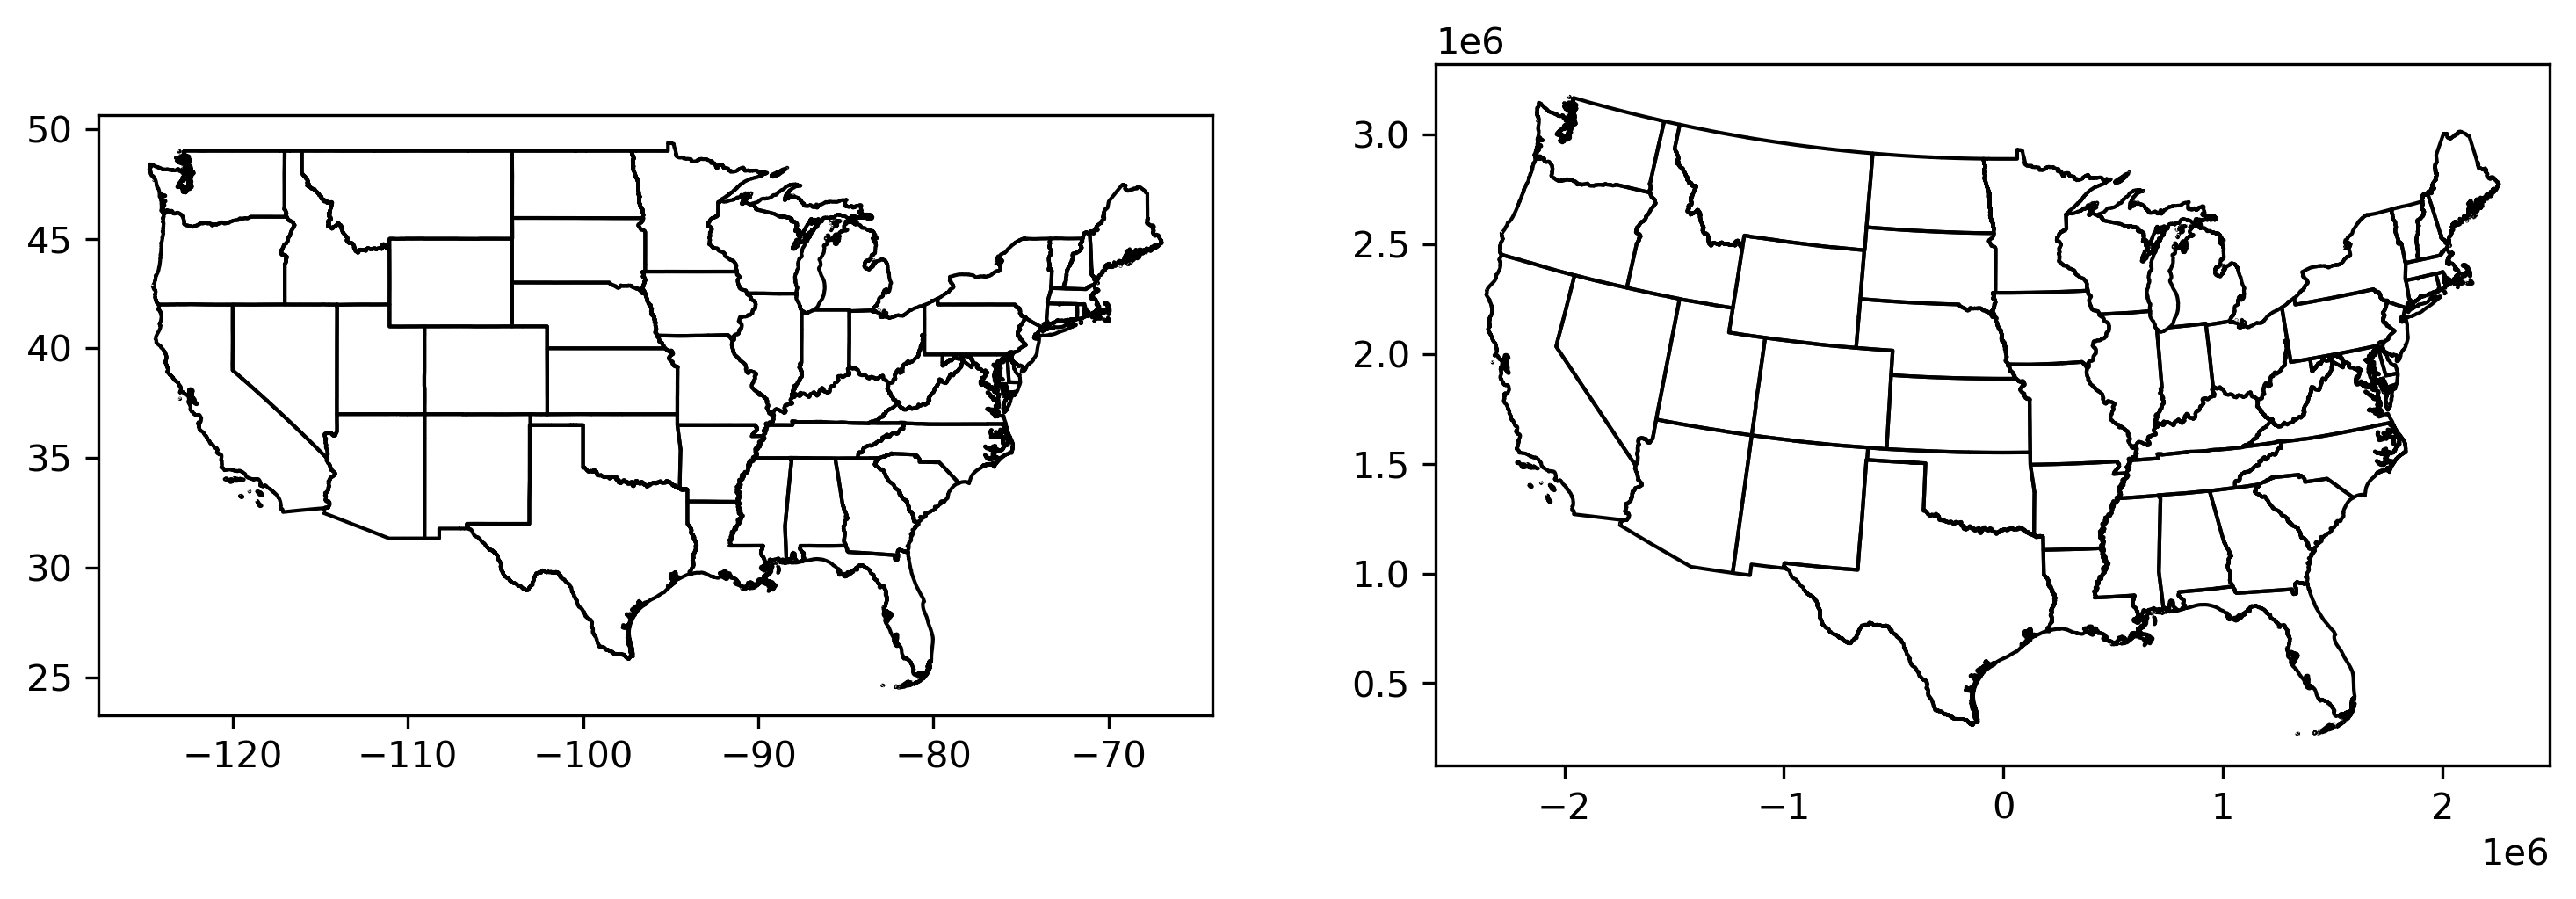

In [100]:
#Get shapefile data directly from census URLs
#########

url_state = 'https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip'
state_gdf = gpd.read_file(url_state)

#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

#Convert to EPSG 4326 to Mask WorldClim Rasters #North American Albers is 5070
state_gdf = state_gdf.to_crs(4326)

#And a 5070 version:
state_gdf_5070 = state_gdf.to_crs(5070)


#Plot both:
fig, ax1 = plt.subplots(1,2, figsize=(12, 8), dpi=300)

state_gdf.plot(ax = ax1[0], linewidth = 1, edgecolor = 'black', facecolor = 'none')
state_gdf_5070.plot(ax = ax1[1], linewidth = 1, edgecolor = 'black', facecolor = 'none');

## Masking Rasters: Mean Temperature by State?

- Motivating question: can we calculate mean temperature for each state?
- Let's mask by our state polygons, and get the mean across each...


### First let's just mask Arizona...

In [101]:
#Need this bad boy:
import rasterio.mask

<AxesSubplot: >

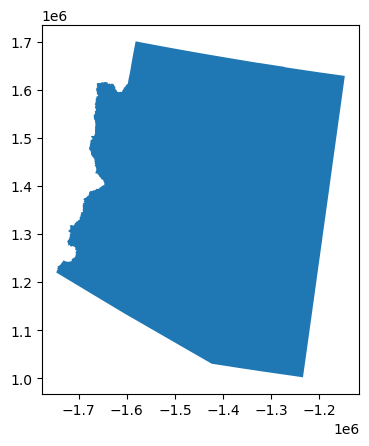

In [102]:
#Let's get a set of shapes to mask With...
#Do Arizona, STATEFP = 04
state_fp = '04'
shapes =  state_gdf_5070.loc[state_gdf_5070.STATEFP == state_fp].geometry

#And check:
shapes.plot()

In [103]:
#Note that shapes is a GeoSeries
shapes

39    POLYGON ((-1746851.979 1221914.112, -1746649.6...
Name: geometry, dtype: geometry

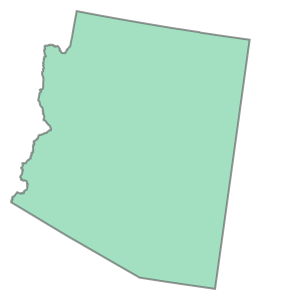

In [104]:
#Getting the first element gives us:
shapes.iloc[0]

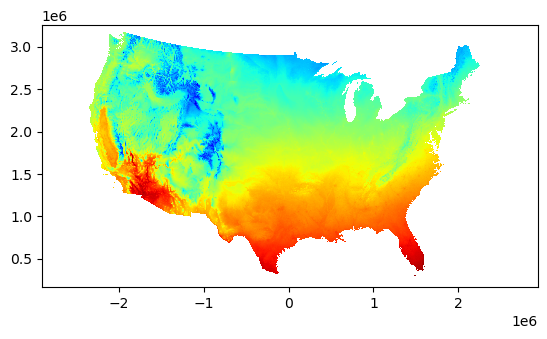

In [105]:
#Reopen our Albers Projection of the US Mean Historical Temperature:
########

filename = 'USA_Mean_Temp_30seconds_EPSG5070.tif'
dataset_5070 = rasterio.open(filename)

#And quickly show:
show(dataset_5070, cmap='jet', interpolation="none");

In [106]:
#Let's get min and max for plotting below:
#We'll also compare future climate to this:
band1_5070_masked = dataset_5070.read(masked=True)

print(np.min(band1_5070_masked))
print(np.max(band1_5070_masked))

-7.0958333
25.629166


<AxesSubplot: >

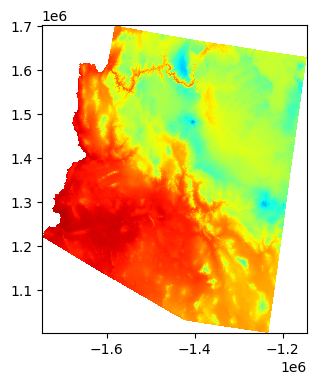

In [119]:
#Now, mask to just Arizona:

#Get the mask
#Note that our out_image is a masked numpy array, need to set filled = False
out_image, out_transform = rasterio.mask.mask(dataset_5070, shapes, crop=True, filled=False,
                                              invert=False, all_touched=False, nodata=dataset_5070.nodata)

#And plot:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

#Note the vmin and vmax:
#Try with and without
show(out_image, ax=ax1, cmap='jet', interpolation='none', transform=out_transform, vmin=-7.0958333, vmax=25.629166)


In [115]:
#Note we have a masked array (assuming we set filled=False)
out_image

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=-3.4e+38,
  dtype=float32)

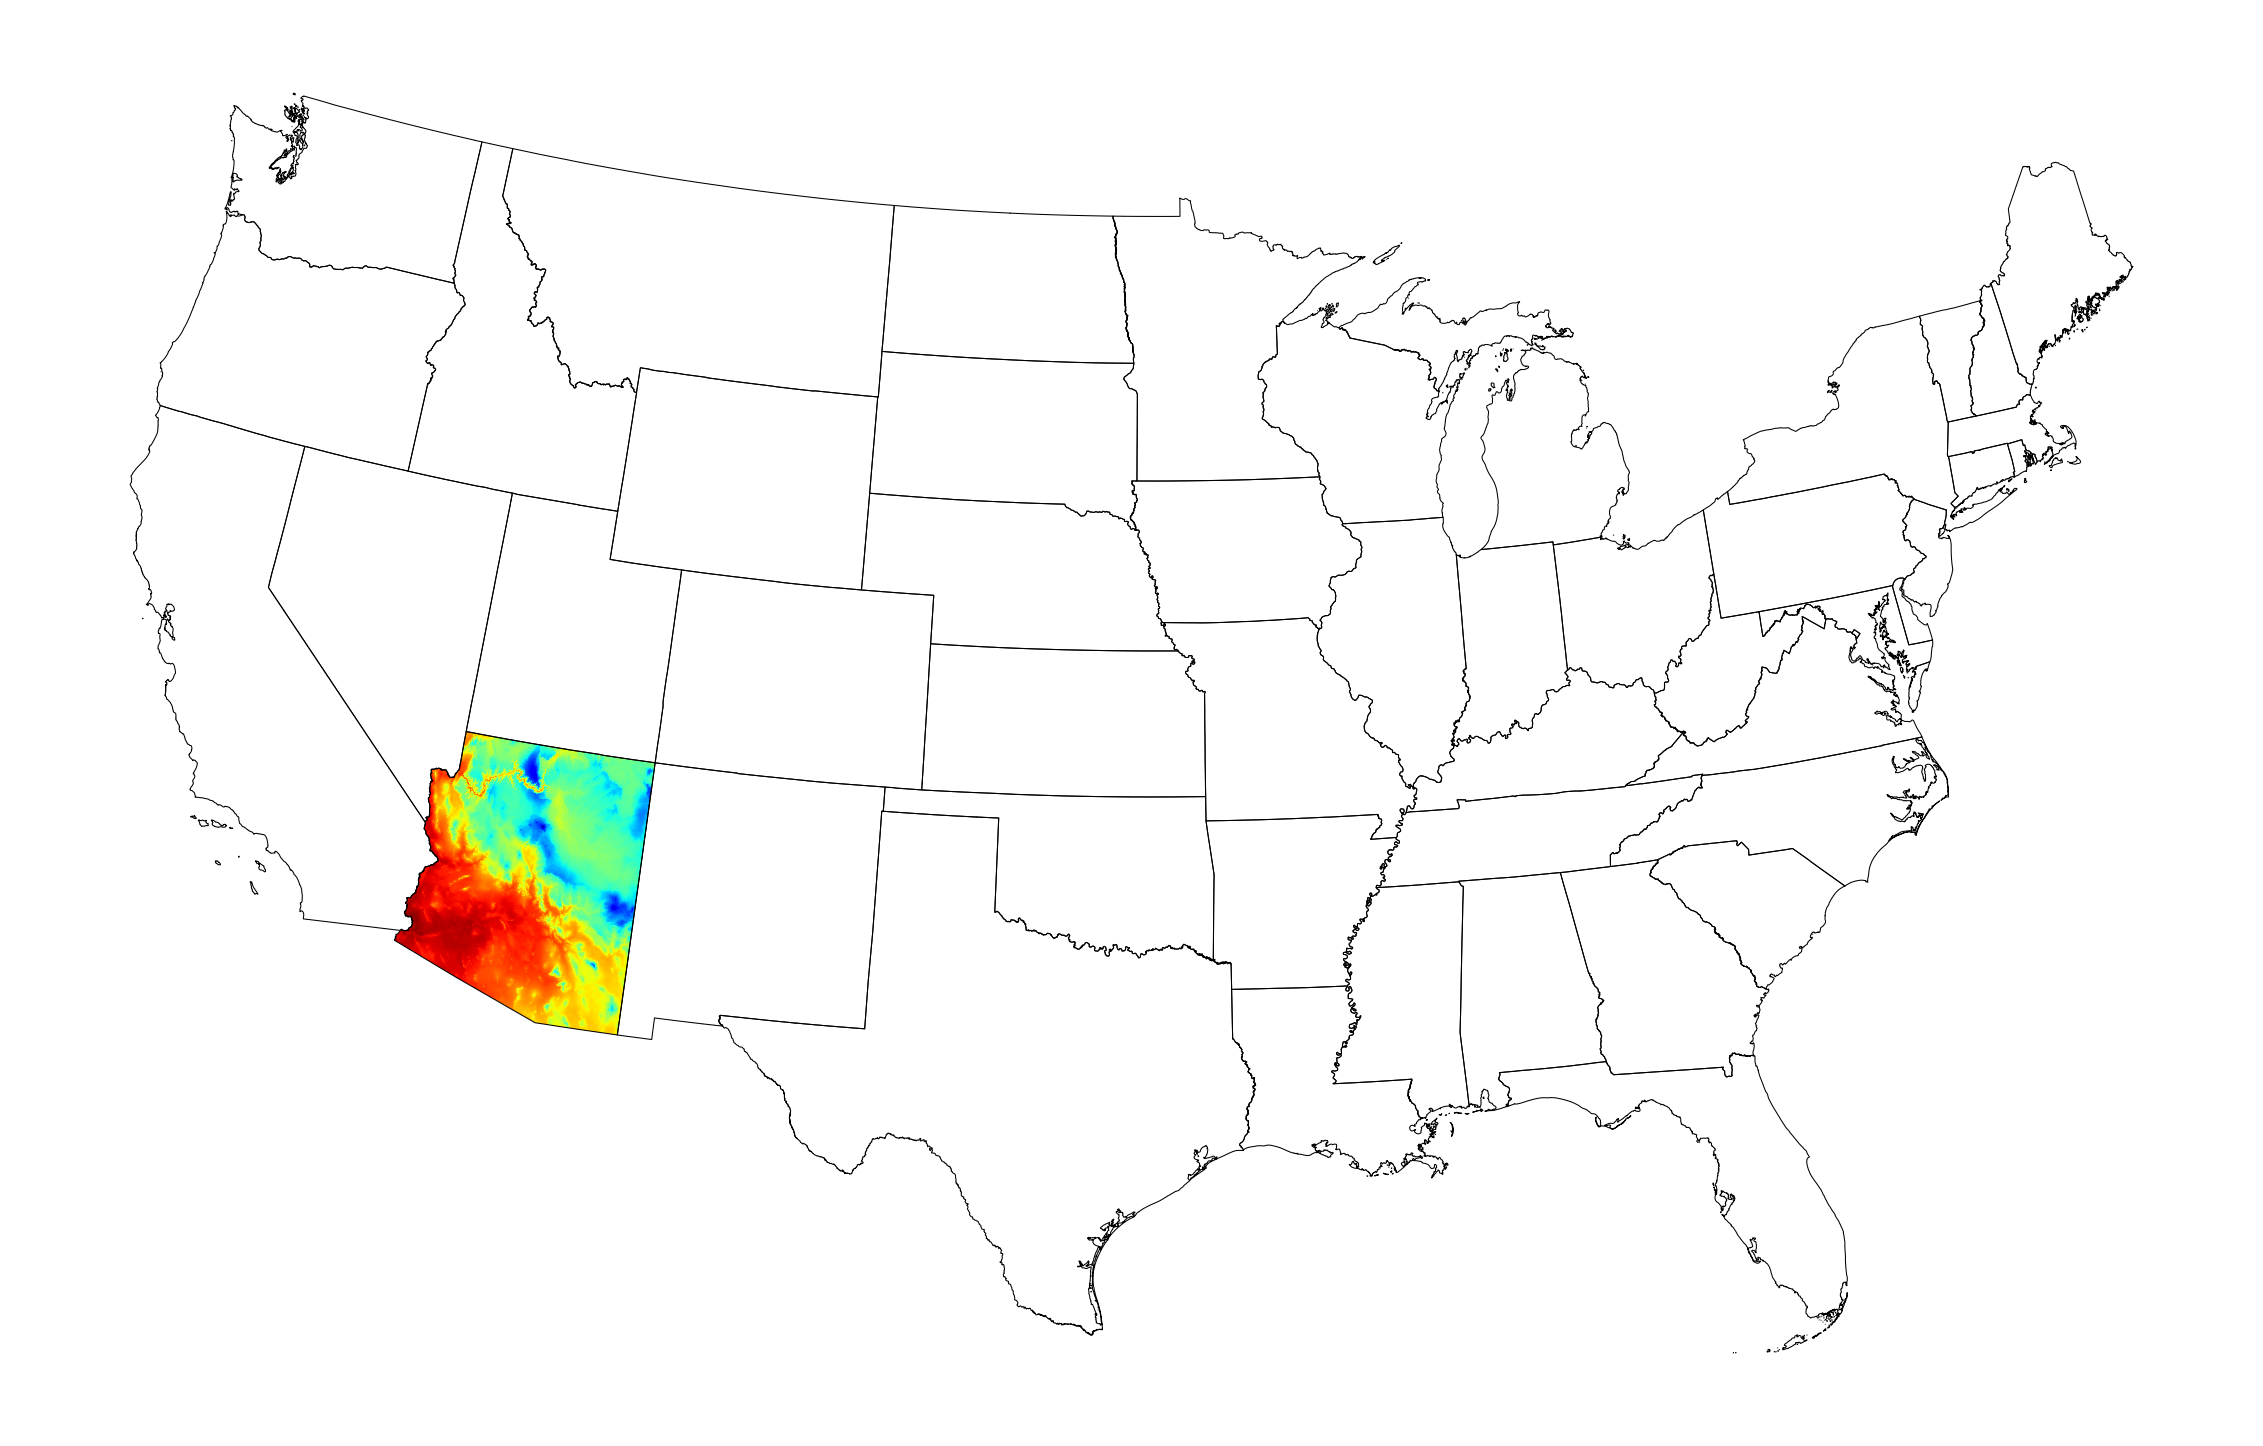

In [116]:
#Can also plot with the rest of the US:
###########

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

#Our masked array
show(out_image, ax=ax1, cmap='jet', interpolation='none', transform=out_transform)

#Plus US:
state_gdf_5070.plot(ax = ax1, facecolor = 'none', edgecolor='black', linewidth=.25)

ax1.set_axis_off()

In [120]:
#Now, mean AZ temperature is:
########

out_image.mean()*1.8 + 32

59.96698588449702

### For all states...

- Let's just iterate through every state and mask
- Save the mean and standard deviation of the temperature

In [121]:
#Iterate through each state, mask, and get mean temperature
#Also get the standard deviation

state_gdf_5070['T_Mean'] = 0
state_gdf_5070['T_SD'] = 0

for fp in state_gdf_5070.STATEFP:

    #Mask this state:
    state_fp = fp
    shapes =  state_gdf_5070.loc[state_gdf_5070.STATEFP == state_fp].geometry

    #Get the mask
    out_image, out_transform = rasterio.mask.mask(dataset_5070, shapes, crop=True, filled=True,
                                                  invert=False, nodata=dataset_5070.nodata)

    #And mask out nodata
    state_masked = np.ma.masked_where(out_image == dataset_5070.nodata, out_image)
    
    print(state_masked.mean()*1.8 + 32)
    
    state_gdf_5070['T_Mean'].loc[state_gdf_5070.STATEFP == state_fp] = state_masked.mean()*1.8 + 32
    state_gdf_5070['T_SD'].loc[state_gdf_5070.STATEFP == state_fp] = state_masked.std()*1.8 + 32

41.18497175254427
54.31215591777317
60.37508717860564
40.820389819756286
55.30488091458702
53.48677138114603
47.88996714955033
51.50163628031521
54.47528419916169
63.57423707724952
63.225505243197546
40.97234542455655
43.21982678067701
54.629491711740975
42.173251884890135
45.62192767240552
48.49943012241014
59.690408577765595
51.59679074482999
52.46896245898337
49.03071077562187
44.44401364115521
44.94425265638696
42.50128194877535
55.381459548006774
42.35843507850734
56.557352941176475
70.59258878536934
49.51902427210274
57.382588372093025
48.03679382520215
62.69432848848241
44.37042560924433
57.42126509569045
48.914127587002376
59.96698588449702
64.70474583046482
55.200773834483286
51.87724218019369
46.624848948194455
49.29348582605162
62.412132658670316
46.35526708815845
66.19743317160894
40.77685390599828
50.56329236227706
43.13517008215817
58.818185957080026
47.43377199205448


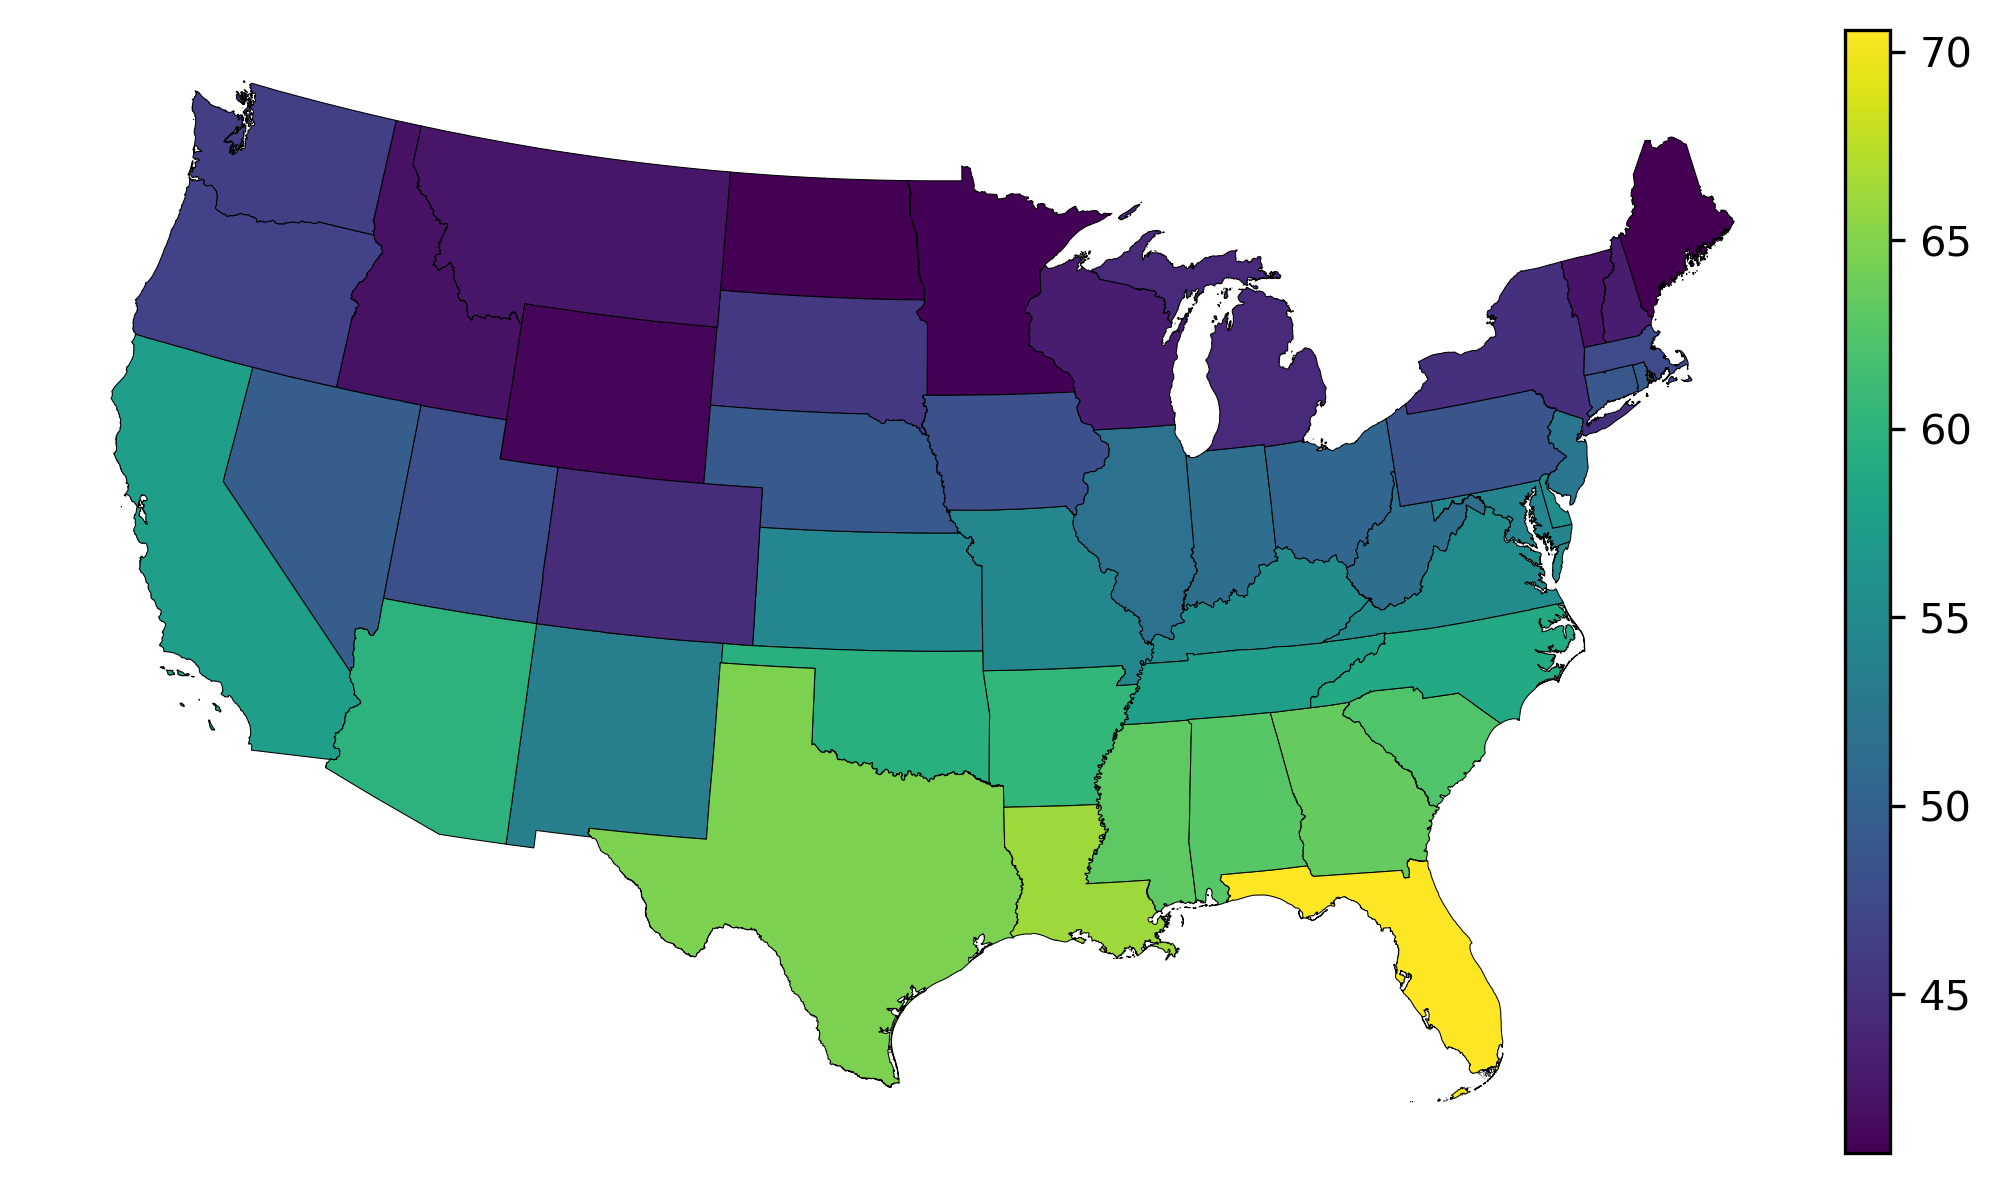

In [128]:
#And plot:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

#Set up colorbar:
########
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.1)

#Map: T_Mean vs. T_SD:
state_gdf_5070.plot(ax = ax1, column = 'T_Mean', edgecolor='black', linewidth=.25, legend=True, cax=cax)

ax1.set_axis_off()


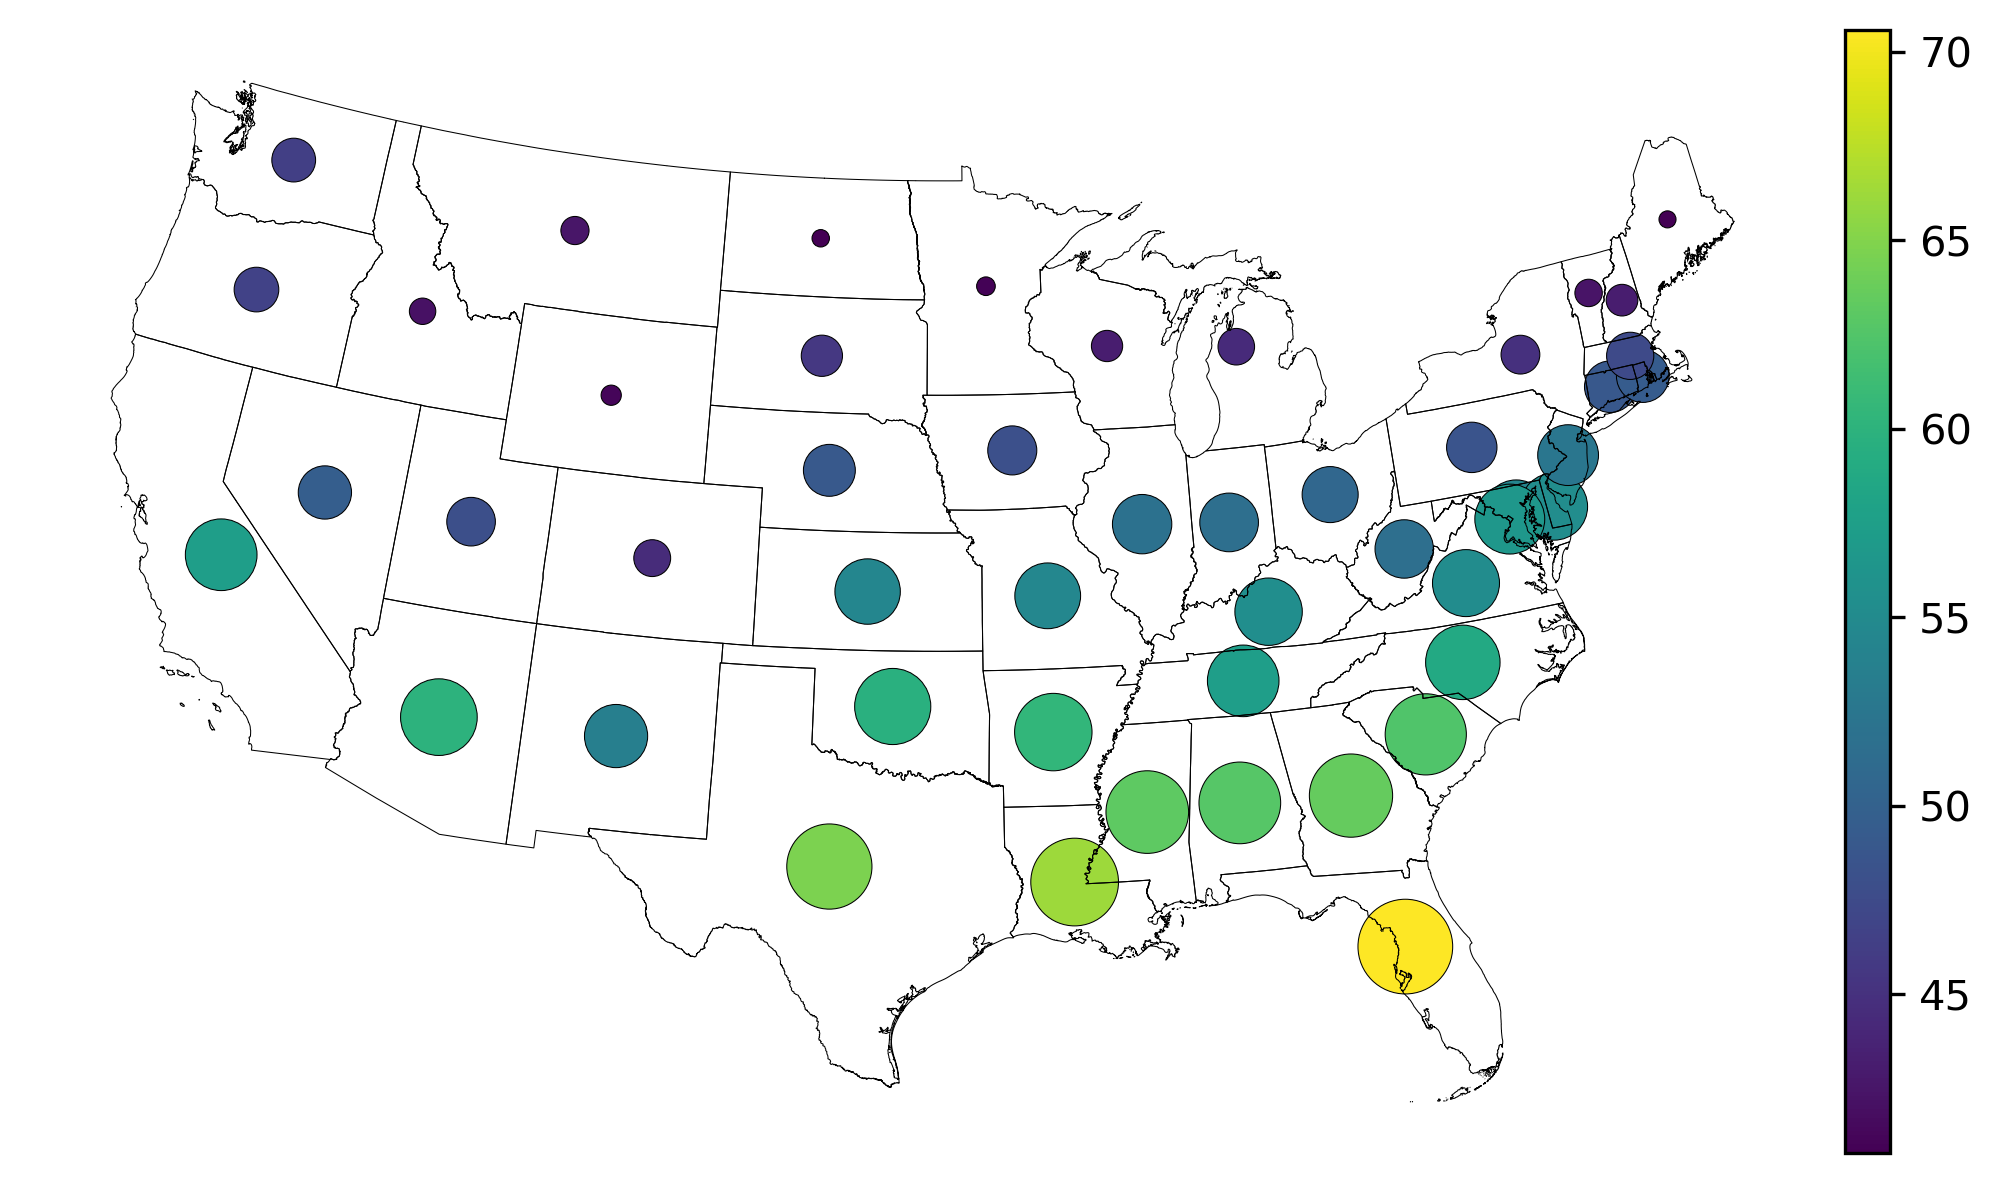

In [123]:
#Plot as centroids:
###################

#Add our centroid column
state_gdf_5070['centroid_column'] = state_gdf_5070.centroid

state_gdf_5070 = state_gdf_5070.set_geometry('centroid_column')


#Make the plot
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

#Set up colorbar:
########
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.1)

#Map:
state_gdf_5070.plot(ax = ax1,
                markersize= (state_gdf_5070.T_Mean - np.amin(state_gdf_5070.T_Mean) + 1) / (np.amax(state_gdf_5070.T_Mean) - np.amin(state_gdf_5070.T_Mean))*500,
                column = 'T_Mean', edgecolor='black', linewidth=.25, legend=True, cax=cax)

#Add the states as background
state_gdf_5070 = state_gdf_5070.set_geometry('geometry')
state_gdf_5070.plot(ax = ax1, facecolor = 'none', edgecolor='black', linewidth=.25)

ax1.set_axis_off()


In [124]:
#Warmest states?
#######

state_gdf_5070.sort_values(by = 'T_Mean', ascending=False).head(10)

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
30      12  00294478  0400000US12    12     FL         Florida   00   
50      22  01629543  0400000US22    22     LA       Louisiana   00   
40      48  01779801  0400000US48    48     TX           Texas   00   
12      13  01705317  0400000US13    13     GA         Georgia   00   
13      28  01779790  0400000US28    28     MS     Mississippi   00   
35      01  01779775  0400000US01    01     AL         Alabama   00   
47      45  01779799  0400000US45    45     SC  South Carolina   00   
4       05  00068085  0400000US05    05     AR        Arkansas   00   
39      04  01779777  0400000US04    04     AZ         Arizona   00   
20      40  01102857  0400000US40    40     OK        Oklahoma   00   

           ALAND       AWATER  \
30  138961722096  45972570361   
50  111915258185  23736382213   
40  676681550479  18978390713   
12  149486624386   4418360134   
13  121533935354   3914344129   
35  131175477769   4591897964   
47   77866200776   5074243221   
4   134660767709   3121950081   
39  294363973043    855871553   
20  177664154114   3373725677   

                                             geometry     T_Mean       T_SD  \
30  MULTIPOLYGON (((1563999.297 344938.802, 156407...  70.592589  34.880514   
50  MULTIPOLYGON (((687937.424 779840.415, 688125....  66.197433  33.729716   
40  MULTIPOLYGON (((123936.102 740130.354, 124036....  64.704746  36.077696   
12  MULTIPOLYGON (((1390721.939 1022647.032, 13908...  63.574237  34.957177   
13  MULTIPOLYGON (((719952.837 821678.163, 721081....  63.225505  33.780699   
35  MULTIPOLYGON (((760323.731 857474.728, 760524....  62.694328  34.324298   
47  MULTIPOLYGON (((1523538.251 1238064.654, 15236...  62.412133  33.836153   
4   POLYGON ((122656.347 1495564.869, 122680.321 1...  60.375087  33.889255   
39  POLYGON ((-1746851.979 1221914.112, -1746649.6...  59.966986  40.522903   
20  POLYGON ((-620696.279 1520595.500, -620035.123...  59.690409  33.787498   

                     centroid_column  
30    POINT (1323191.850 711225.618)  
50     POINT (383060.859 894741.896)  
40    POINT (-314255.003 938838.540)  
12   POINT (1168723.597 1140510.096)  
13    POINT (589584.307 1093659.180)  
35    POINT (852662.593 1119773.807)  
47   POINT (1381312.074 1314628.530)  
4     POINT (322409.377 1321069.390)  
39  POINT (-1424359.956 1363564.300)  
20   POINT (-134144.957 1393804.694)

In [126]:
#Most variable states?
########

state_gdf_5070.sort_values(by = 'T_SD', ascending=False).head(5)

STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
37      06  01779778  0400000US06    06     CA  California   00  403671756816   
39      04  01779777  0400000US04    04     AZ     Arizona   00  294363973043   
24      08  01779779  0400000US08    08     CO    Colorado   00  268418796417   
8       35  00897535  0400000US35    35     NM  New Mexico   00  314198560947   
31      32  01779793  0400000US32    32     NV      Nevada   00  284537290201   

         AWATER                                           geometry     T_Mean  \
37  20293573058  MULTIPOLYGON (((-2066923.367 1403703.122, -206...  57.421265   
39    855871553  POLYGON ((-1746851.979 1221914.112, -1746649.6...  59.966986   
24   1185716938  POLYGON ((-1123222.584 1807303.824, -1121310.5...  44.444014   
8     726482113  POLYGON ((-1231344.076 1018550.430, -1231015.8...  53.486771   
31   1839636284  POLYGON ((-2030317.735 2063307.094, -2030147.7...  49.519024   

         T_SD                   centroid_column  
37  40.922910  POINT (-2043270.835 1825235.915)  
39  40.522903  POINT (-1424359.956 1363564.300)  
24  38.921640   POINT (-817875.672 1815620.722)  
8   37.856695   POINT (-920664.400 1309791.132)  
31  37.840189  POINT (-1748443.517 2002292.444)

### Future Climate Scenarios

- Let's load one future climate scenario

- Plot

- Temperature increase in the US?

- By state? city?

#### First, let's get country vectors

In [129]:
#Get Basic World Political Map:
#####

#Download from Natural Earth if you have not done so!

#fp = 'Data/ne_50m_admin_0_countries.zip'
fp = '../Module_2/Data/ne_50m_admin_0_sovereignty.zip'

#Load as "gdf"
gdf = gpd.read_file(fp)


<AxesSubplot: >

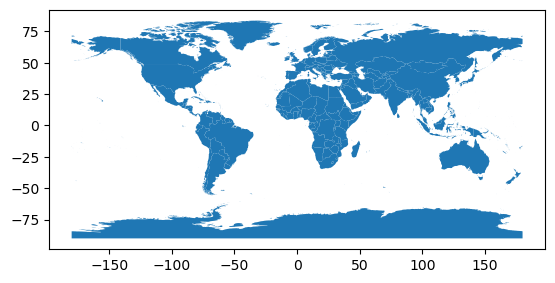

In [130]:
##Quick plot:
gdf.plot()

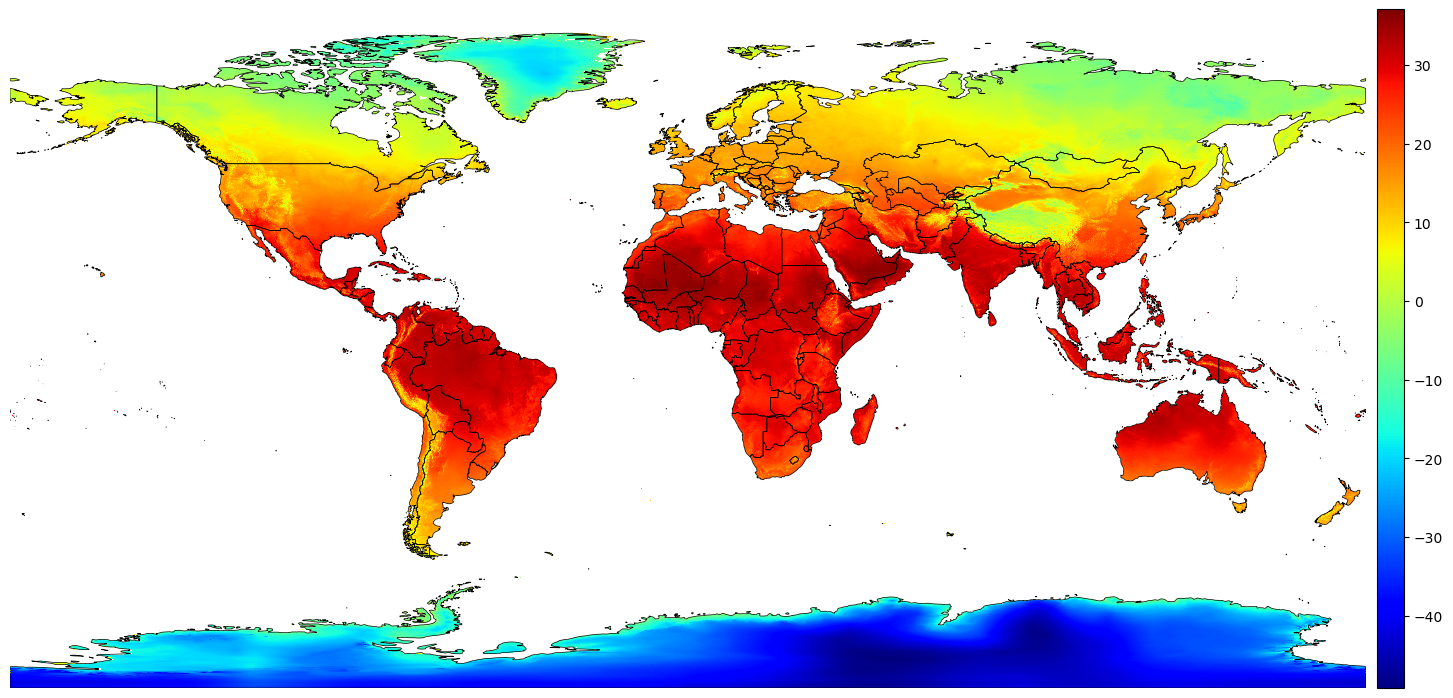

In [93]:
#I downloaded my data to the folder CMIP6_Data...
#Load for 2081-2100
#filename = 'CMIP6_Data\wc2.1_10m_bioc_ACCESS-CM2_ssp370_2081-2100.tif'
filename = 'CMIP6_Data\wc2.1_30s_bioc_ACCESS-CM2_ssp370_2081-2100.tif'

fig1, ax1 = plt.subplots(1,1, figsize=(18, 12))

#Open the file
dataset_future = rasterio.open(filename)

#Show the data...
#Let's show channel 1 = Mean Annual Temperature; Note almost always looks better without interpolation
########
r = show((dataset_future, 1), ax=ax1, cmap='jet', interpolation='none')


#Can add in the political map too:
########
gdf.plot(ax=ax1, facecolor='none', linewidth=.5, edgecolor='black')


#And we can hack in our colorbar:
########
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.1)

im = r.get_images()[0]
fig1.colorbar(im, ax=ax1, cax=cax)

ax1.set_axis_off()

#Close the file!
#dataset_future.close()

### Let's mask/crop, reproject, etc.

<AxesSubplot: >

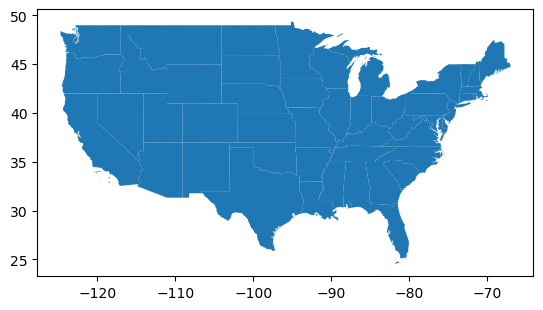

In [131]:
#Let's mask with our US states
shapes =  state_gdf.geometry

#And check:
shapes.plot()

In [ ]:
#Mask to the CONUS first:
#Note that future_us is a numpy array
future_us, future_us_transform = rasterio.mask.mask(dataset_future, shapes, crop=True, filled=True,
                                              invert=False, nodata=dataset_future.nodata)

In [132]:
future_us.shape

(19, 2985, 6939)

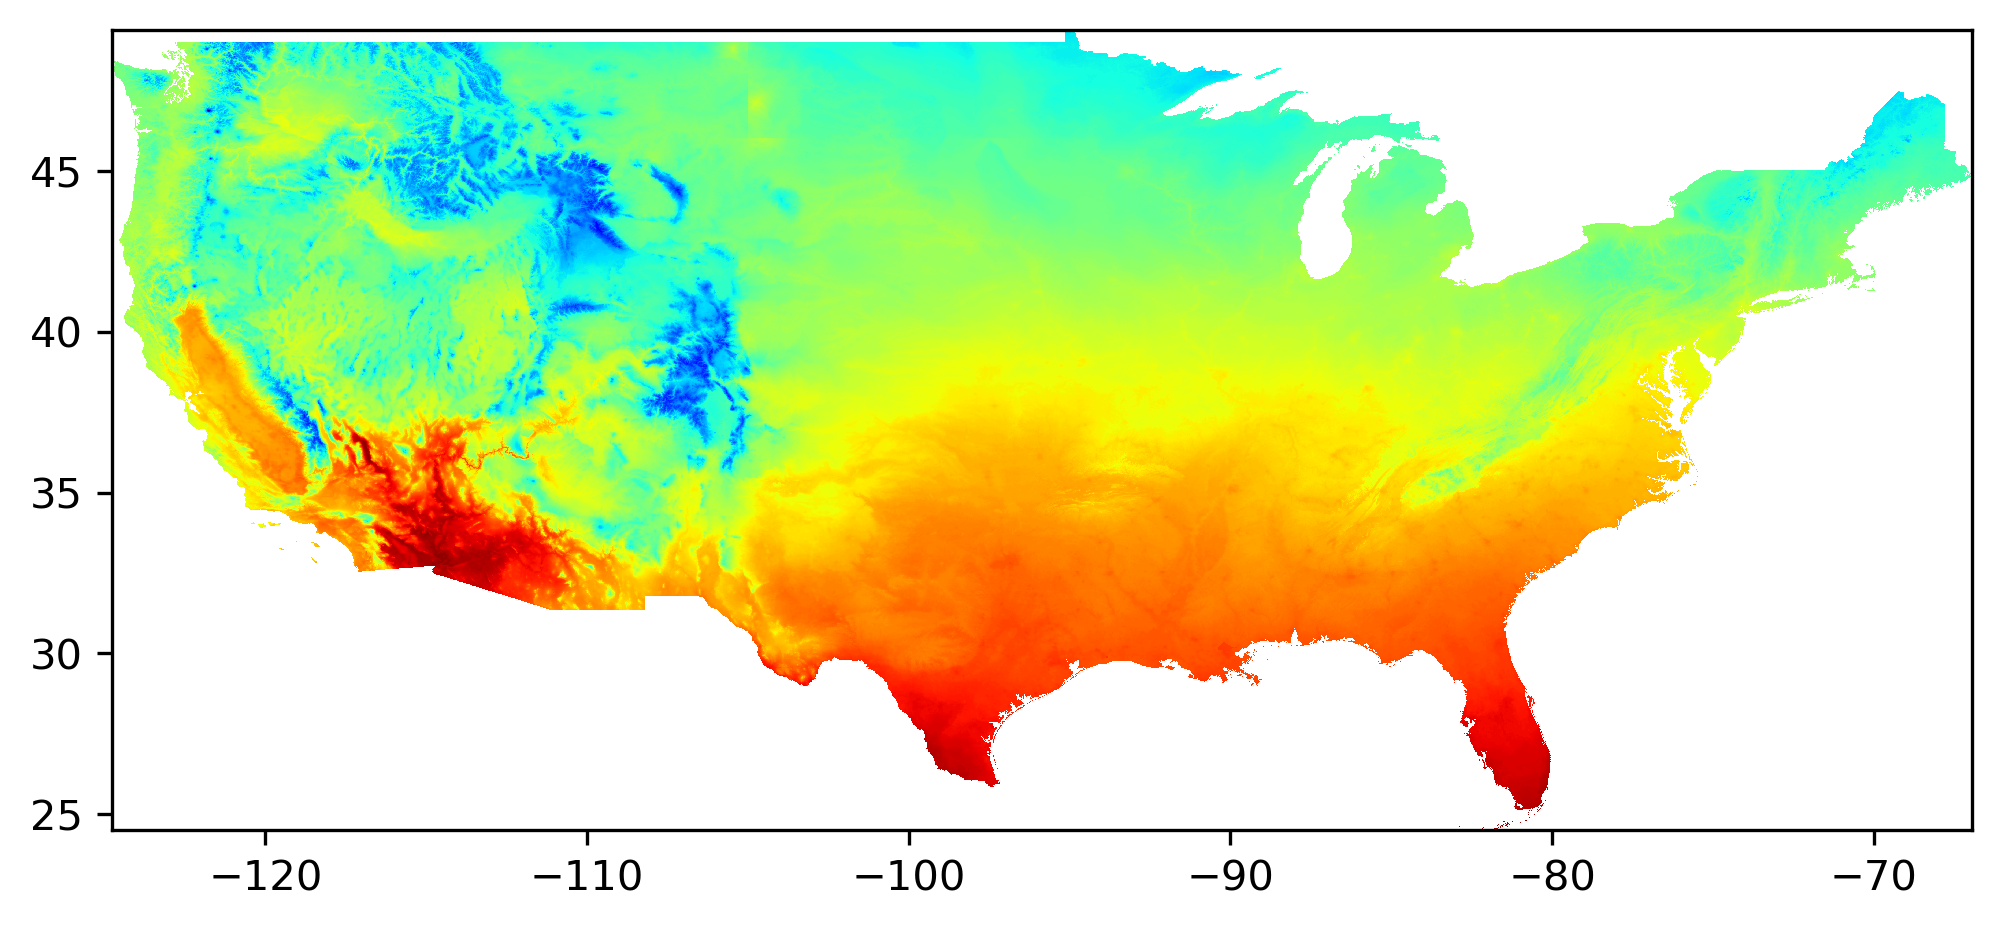

In [133]:
#And plot:
#Plot just the first band, which is mean temperature:

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
show(future_us[0,:,:], ax=ax1, cmap='jet', interpolation='none', transform=future_us_transform);

In [ ]:
#Save our results as a new raster file:
##############
out_meta = dataset_future.meta

out_meta.update({"driver": "GTiff",
                 "height": future_us.shape[1],
                 "width": future_us.shape[2],
                 "transform": future_us_transform,
                 'compress': 'lzw'})

#fp_dest = 'us_future_10m.tif'
fp_dest = 'us_future_30s.tif'

with rasterio.open(fp_dest, "w", **out_meta) as dest:
    dest.write(future_us)
    

In [ ]:
#And Re-Project to Albers Equal Area
dst_crs = 'EPSG:5070'

#source_name = 'us_future_10m.tif'
#dest_name = 'us_future_EPSG5070_10m.tif'

source_name = 'us_future_30s.tif'
dest_name = 'us_future_EPSG5070_30s.tif'


with rasterio.open(source_name) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw'
    })

    
    with rasterio.open(dest_name, 'w', **kwargs) as dst:
        for i in range(1, 2): #src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

<AxesSubplot: >

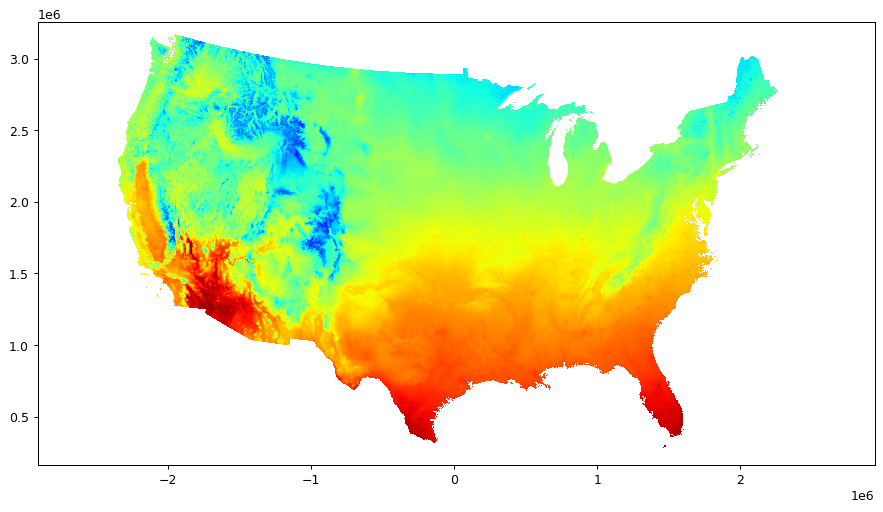

In [134]:
#Read back in and display as check...
#####

#Open the file:
#filename = 'us_future_EPSG5070_10m.tif'
filename = 'us_future_EPSG5070_30s.tif'

dataset_future_5070 = rasterio.open(filename)

#And read the mean temperature band:
band1_future_5070_masked = dataset_future_5070.read(1, masked=True)

fig1, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=90)
show(band1_future_5070_masked, ax=ax1, cmap='jet', transform=dataset_future_5070.transform, interpolation="none")

#dataset_future_5070.close()

In [135]:
#Mean Temperature over the US?
########

band1_future_5070_masked.mean()*1.8+32

62.81775051783153

In [136]:
#vs:
band1_5070_masked.mean() * 1.8 + 32

52.32105638256952

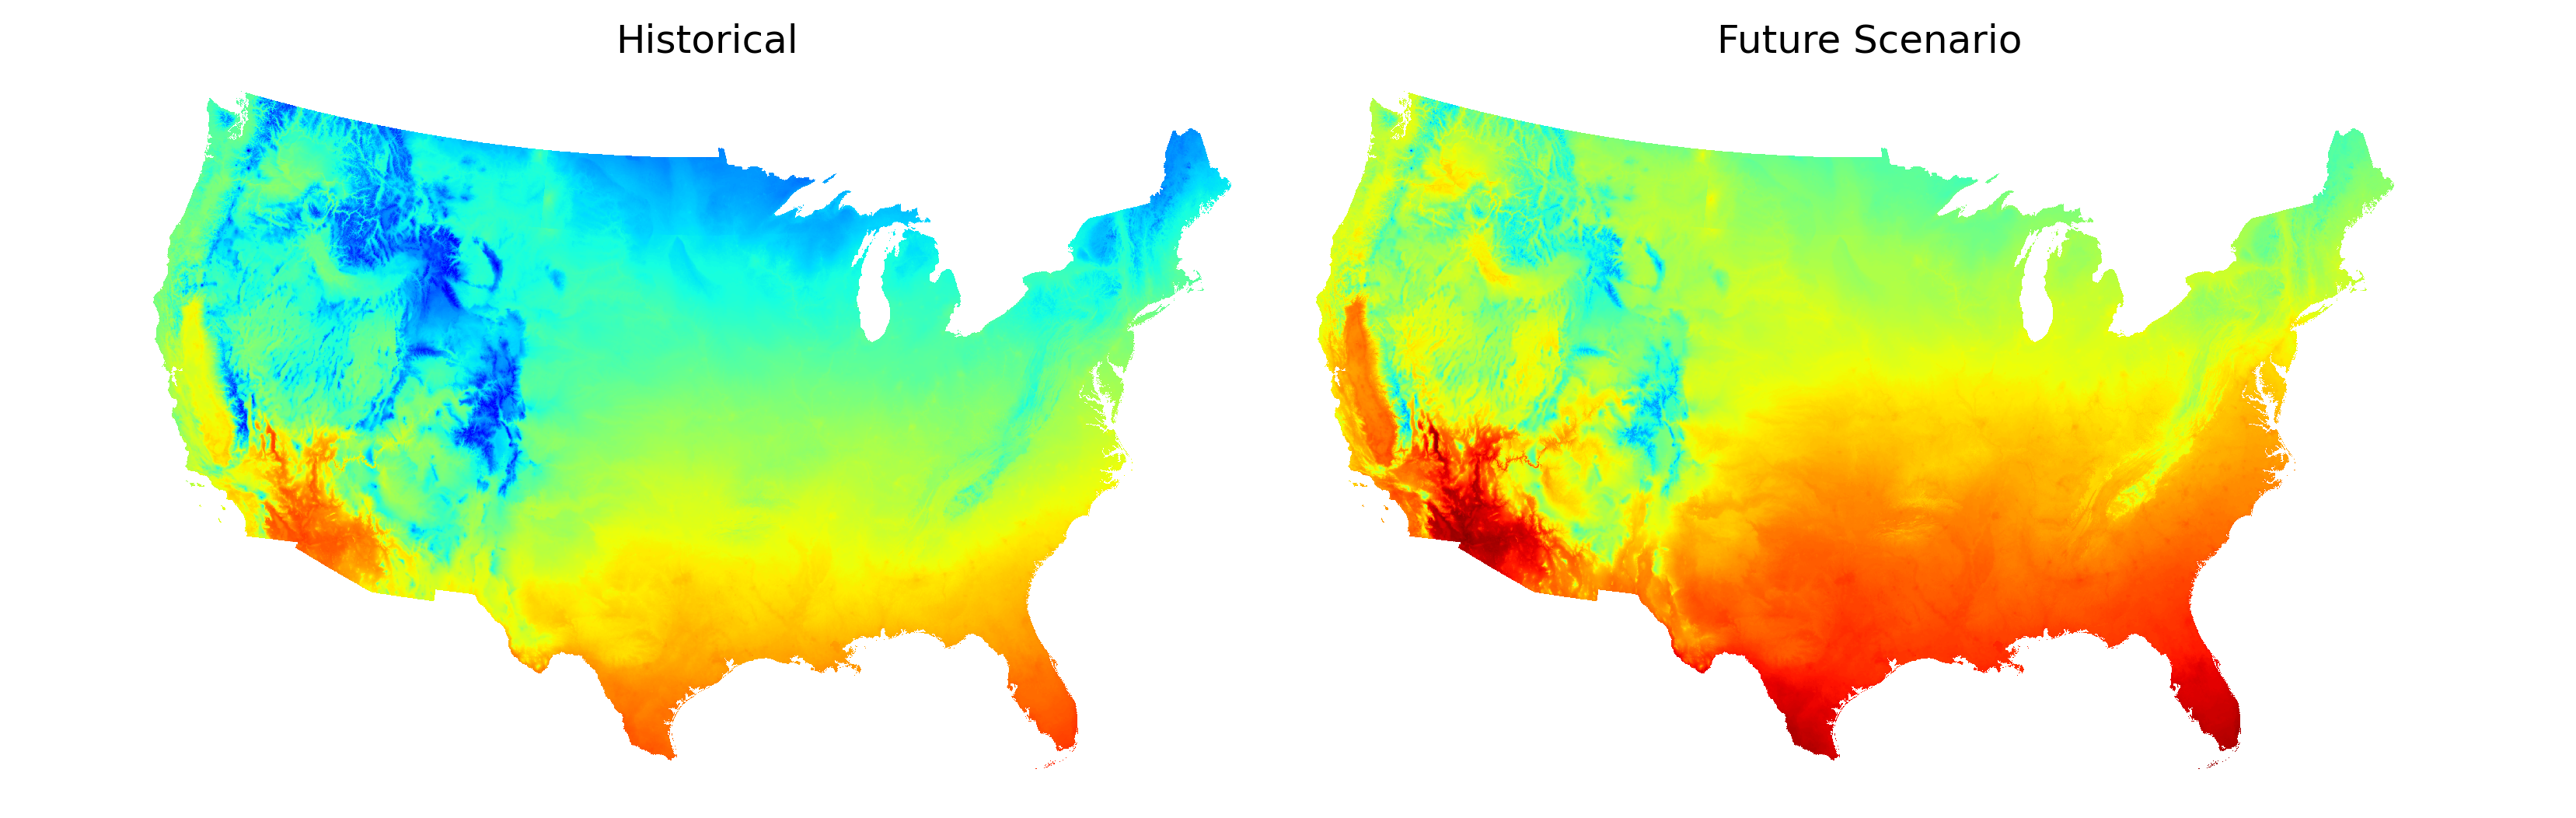

In [137]:
##Side-by-side:
###############


#Get common min/max
Tmin = np.min(band1_5070_masked)
Tmax = np.max(band1_future_5070_masked)

#And plot:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 8), dpi=300)

show(band1_5070_masked, ax=ax1[0], cmap='jet', transform=dataset_5070.transform, interpolation="none",
     vmin=Tmin, vmax=Tmax)

show(band1_future_5070_masked, ax=ax1[1], cmap='jet', transform=dataset_future_5070.transform, interpolation="none",
     vmin=Tmin, vmax=Tmax)


ax1[0].set_title('Historical')
ax1[1].set_title('Future Scenario')

ax1[0].set_axis_off()
ax1[1].set_axis_off()

plt.subplots_adjust(wspace=-.15)

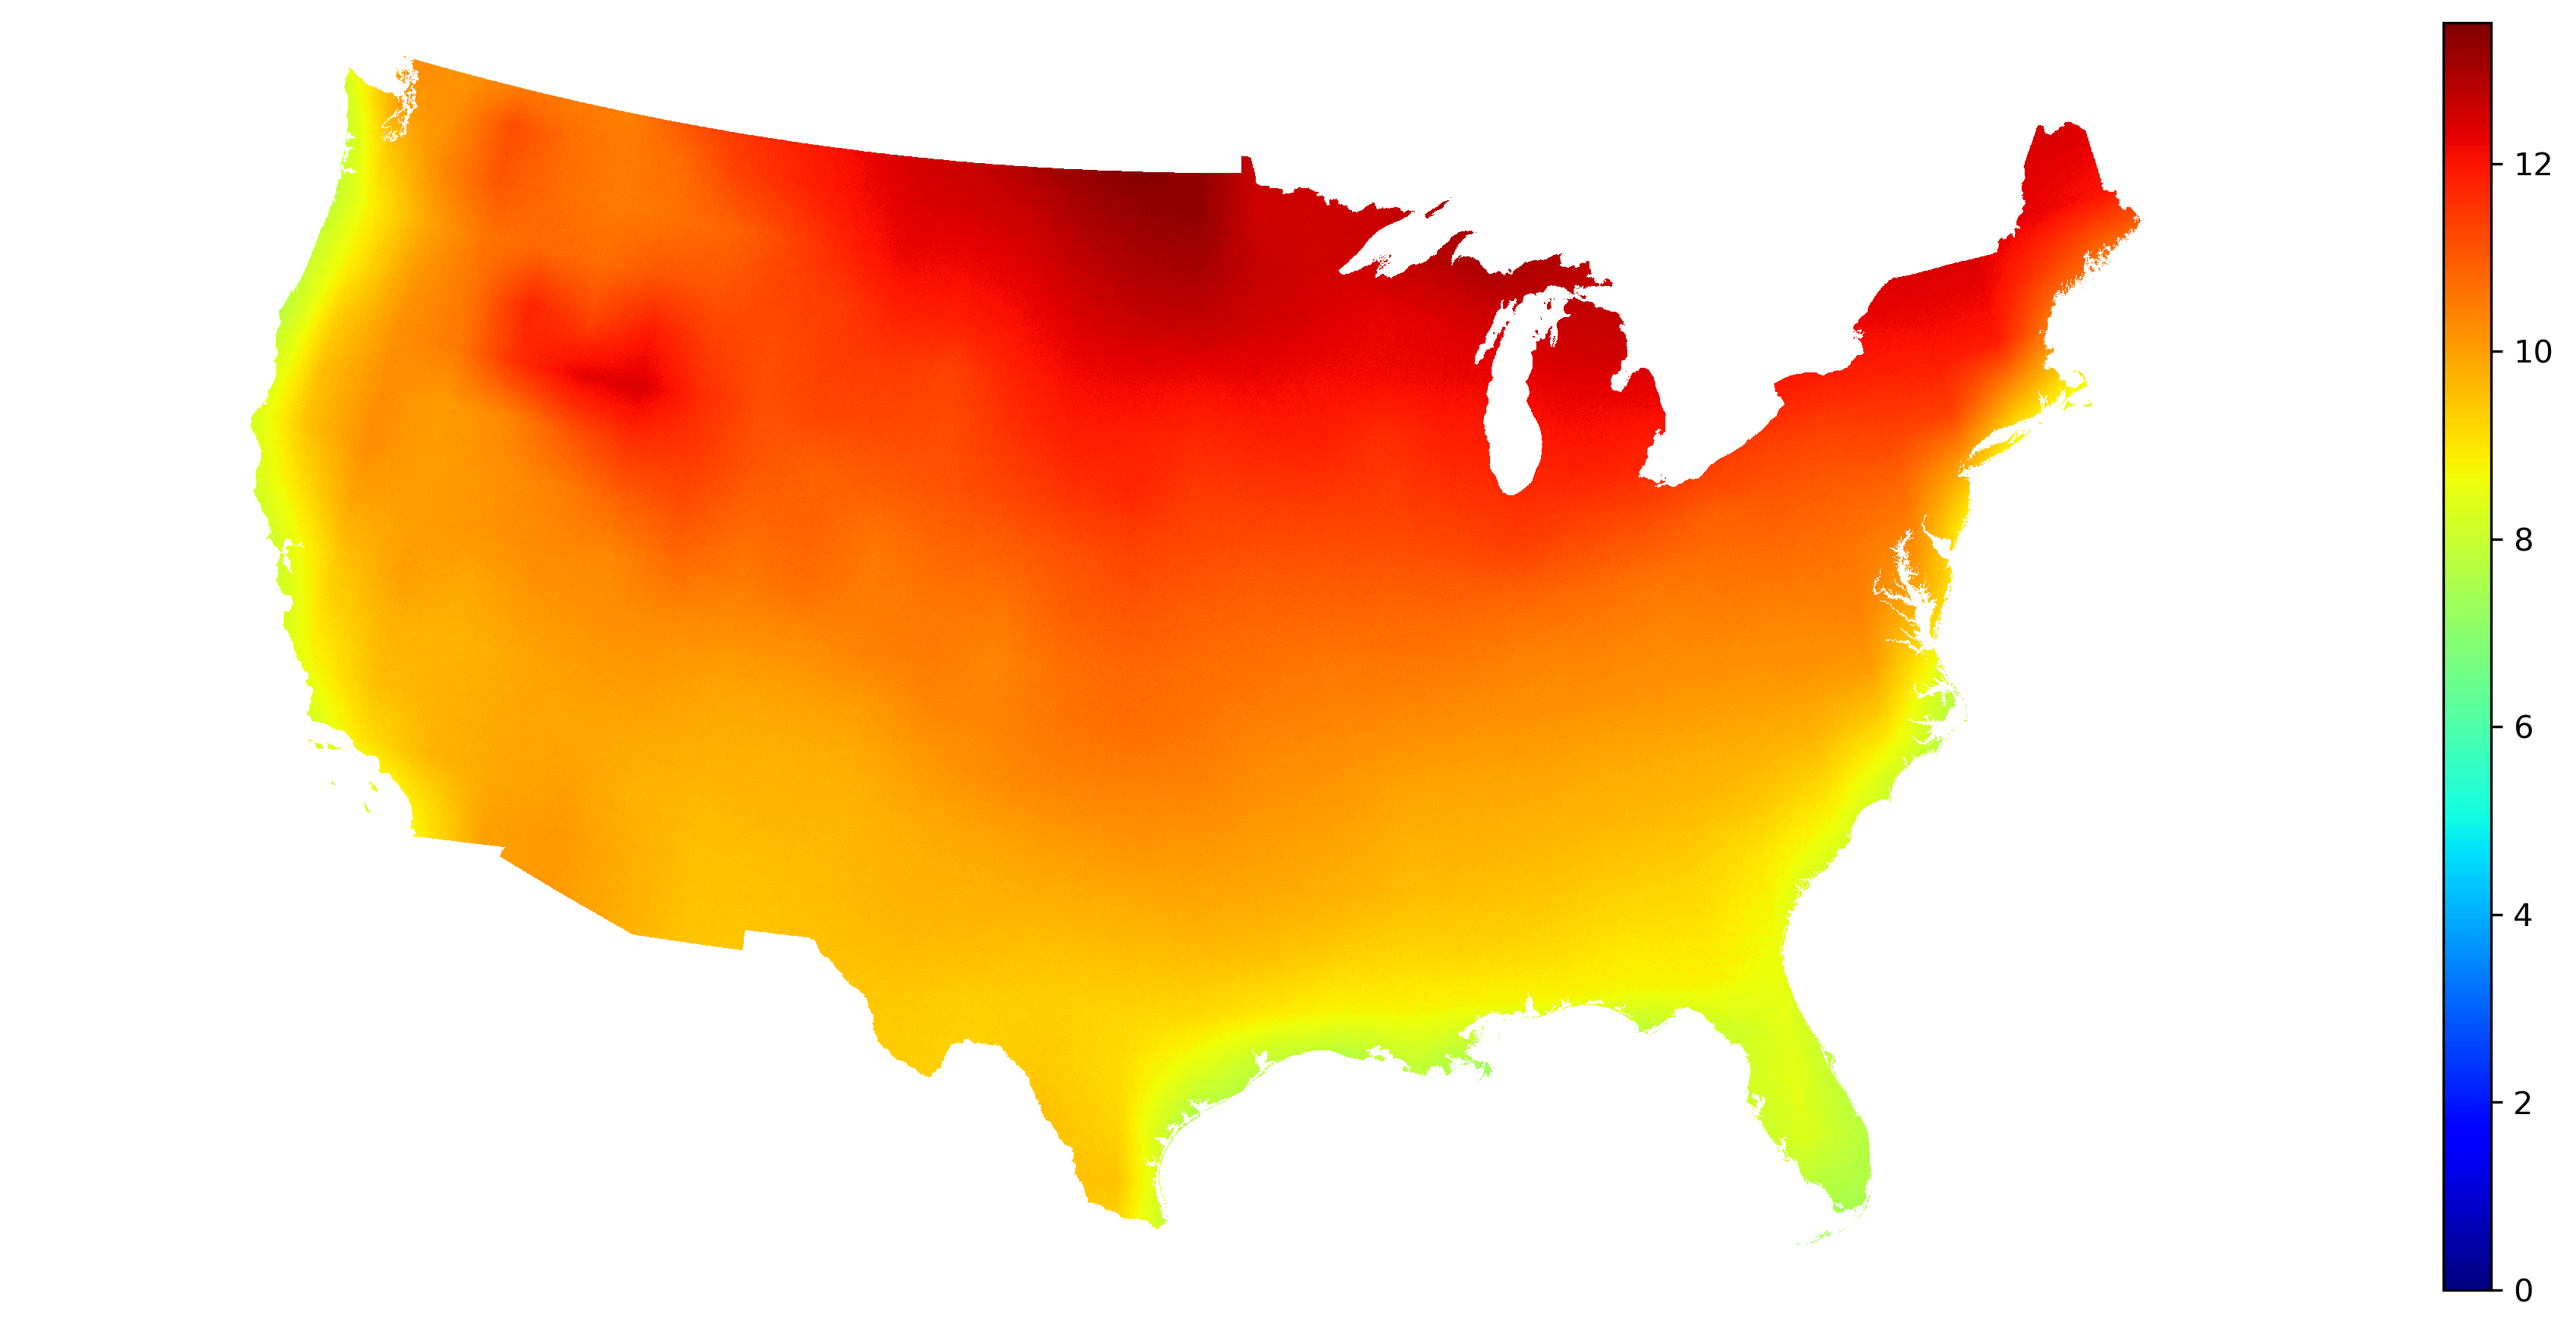

In [138]:
##Difference?
###############
fig1, ax1 = plt.subplots(1,1, figsize=(14, 8), dpi=300)

#Convert to F
r = show((band1_future_5070_masked - band1_5070_masked)*1.8, ax=ax1, cmap='jet', transform=dataset_5070.transform,
     interpolation="none", vmin=0, vmax=13.5)

#Colorbar:
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.1)

im = r.get_images()[0]
fig1.colorbar(im, ax=ax1, cax=cax)

ax1.set_axis_off()

#### Future Climates by State?

In [143]:
#Future climate by-state:
#Iterate through each state, mask, and get mean temperature
#Also get the standard deviation

state_gdf_5070['T_Mean_future'] = 0
state_gdf_5070['T_SD_future'] = 0

for fp in state_gdf_5070.STATEFP:

    #Mask this state:
    state_fp = fp
    shapes =  state_gdf_5070.loc[state_gdf_5070.STATEFP == state_fp].geometry

    #Get the mask
    #Note that out_image is a numpy array
    state_masked, out_transform = rasterio.mask.mask(dataset_future_5070, shapes, crop=True, filled=False,
                                                  invert=False, nodata=dataset_future_5070.nodata)

    print(state_masked[0,:,:].mean()*1.8 + 32)
    
    state_gdf_5070['T_Mean_future'].loc[state_gdf_5070.STATEFP == state_fp] = state_masked[0,:,:].mean()*1.8 + 32
    state_gdf_5070['T_SD_future'].loc[state_gdf_5070.STATEFP == state_fp] = state_masked[0,:,:].std()*1.8 + 32
    

52.35615834602132
64.571911255459
70.35876574740306
53.583119820649344
65.05278444849287
63.24067419673681
58.473232653500844
61.98277442311839
65.24539341898097
72.72728376912167
72.6293081232237
53.48267757997197
54.824084412684236
65.26496258728594
53.58446392005044
57.61795569659565
59.456979074551114
70.04067847296855
62.613459467265145
62.31268169650567
60.373806863437686
54.960621487478846
56.61984106398583
53.96590042909304
65.66646612206188
54.490352263458405
66.91470588235295
78.86108441082723
59.683780399199
67.33549534883721
59.53844701512748
72.04210086903723
56.721766246515394
66.8719599790524
58.92864075270235
69.79163727921201
74.15923289320762
65.31220613941939
62.92895704999884
56.60224035924783
58.622915819955296
71.49519344608879
56.56756019199504
75.05390425970327
52.53358986407115
61.51275679642663
55.28563571628254
68.13789571859226
57.71922024485163


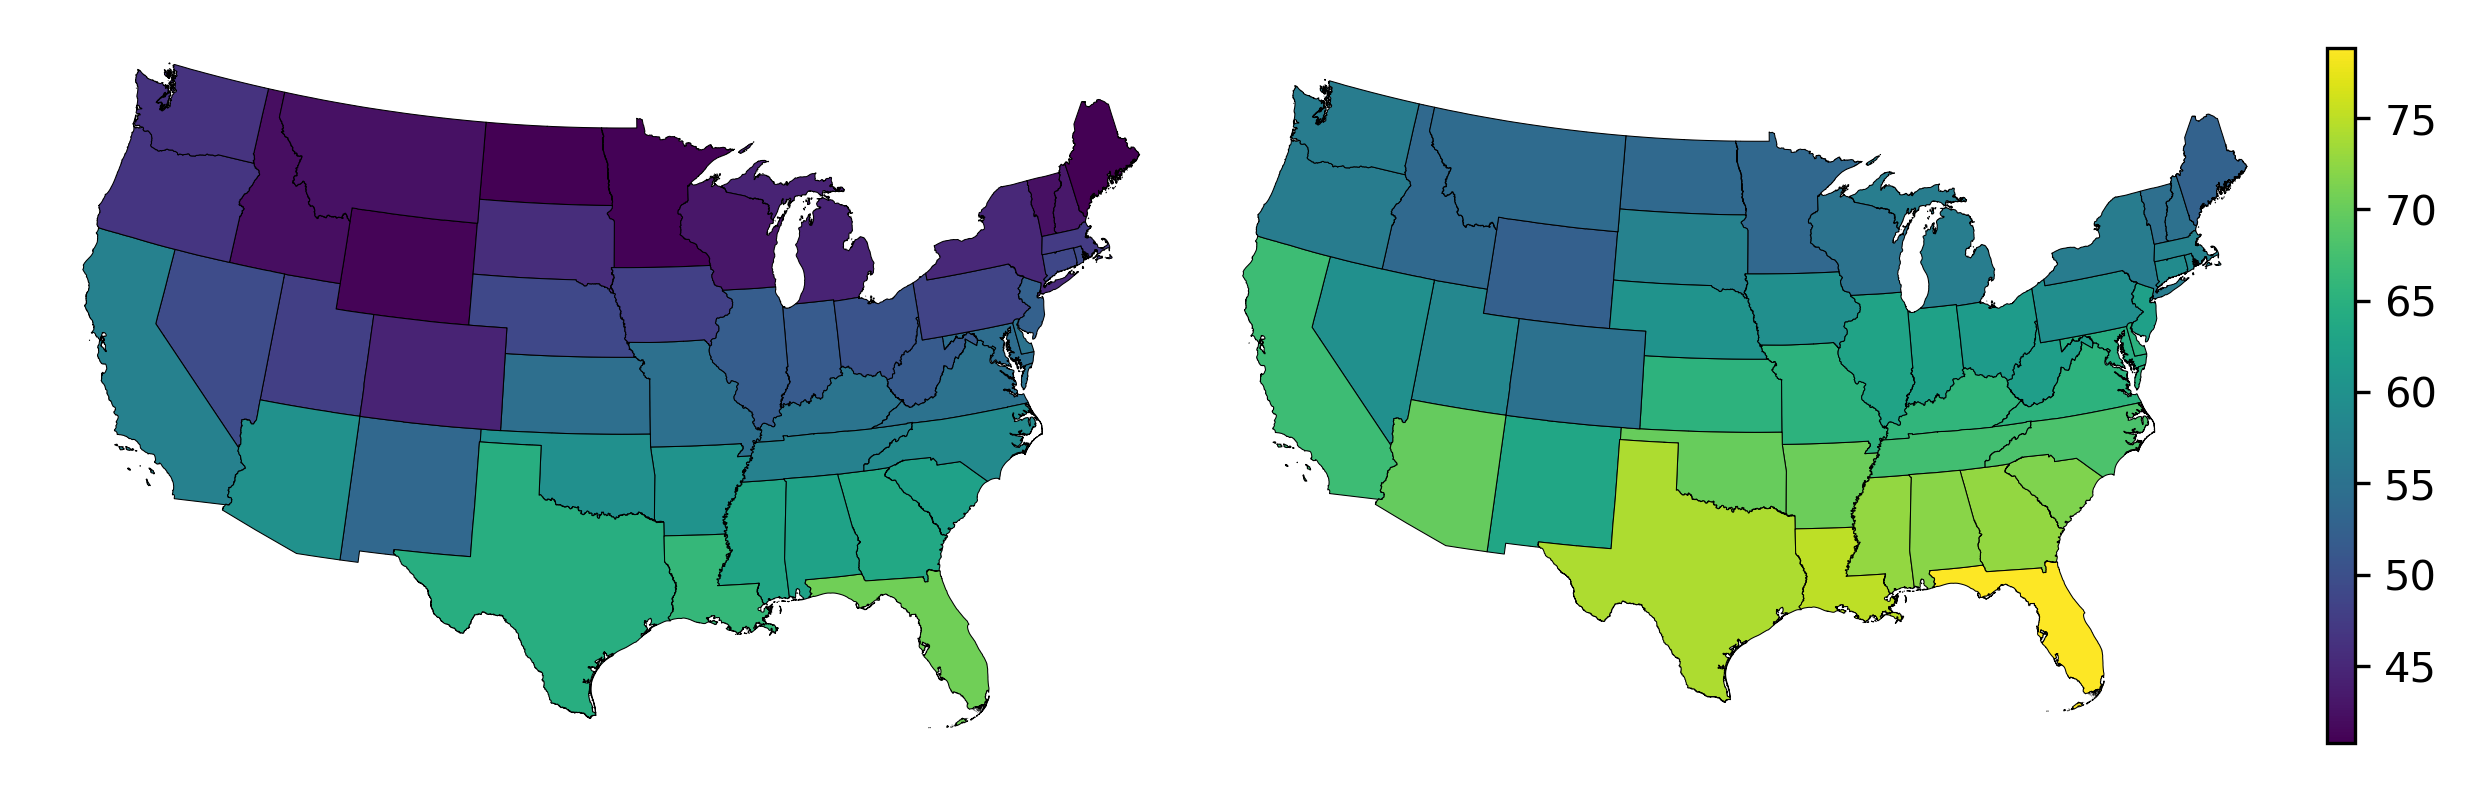

In [144]:
#And plot: Compare Baseline to Future
###########

fig, ax1 = plt.subplots(1, 2, figsize=(10, 6), dpi=300)

#Set up colorbar:
########
divider = make_axes_locatable(ax1[1])
cax = divider.append_axes("right", size="2.5%", pad=0.1)

#Mins/Maxes:
plot_min = state_gdf_5070.T_Mean.min()
plot_max = state_gdf_5070.T_Mean_future.max()


#Map:
state_gdf_5070.plot(ax = ax1[0], column = 'T_Mean', edgecolor='black', linewidth=.25, vmin=plot_min, vmax=plot_max)
state_gdf_5070.plot(ax = ax1[1], column = 'T_Mean_future', edgecolor='black', linewidth=.25,
                    legend=True, cax=cax, vmin=plot_min, vmax=plot_max)

ax1[0].set_axis_off()
ax1[1].set_axis_off()

plt.subplots_adjust(wspace=.0)

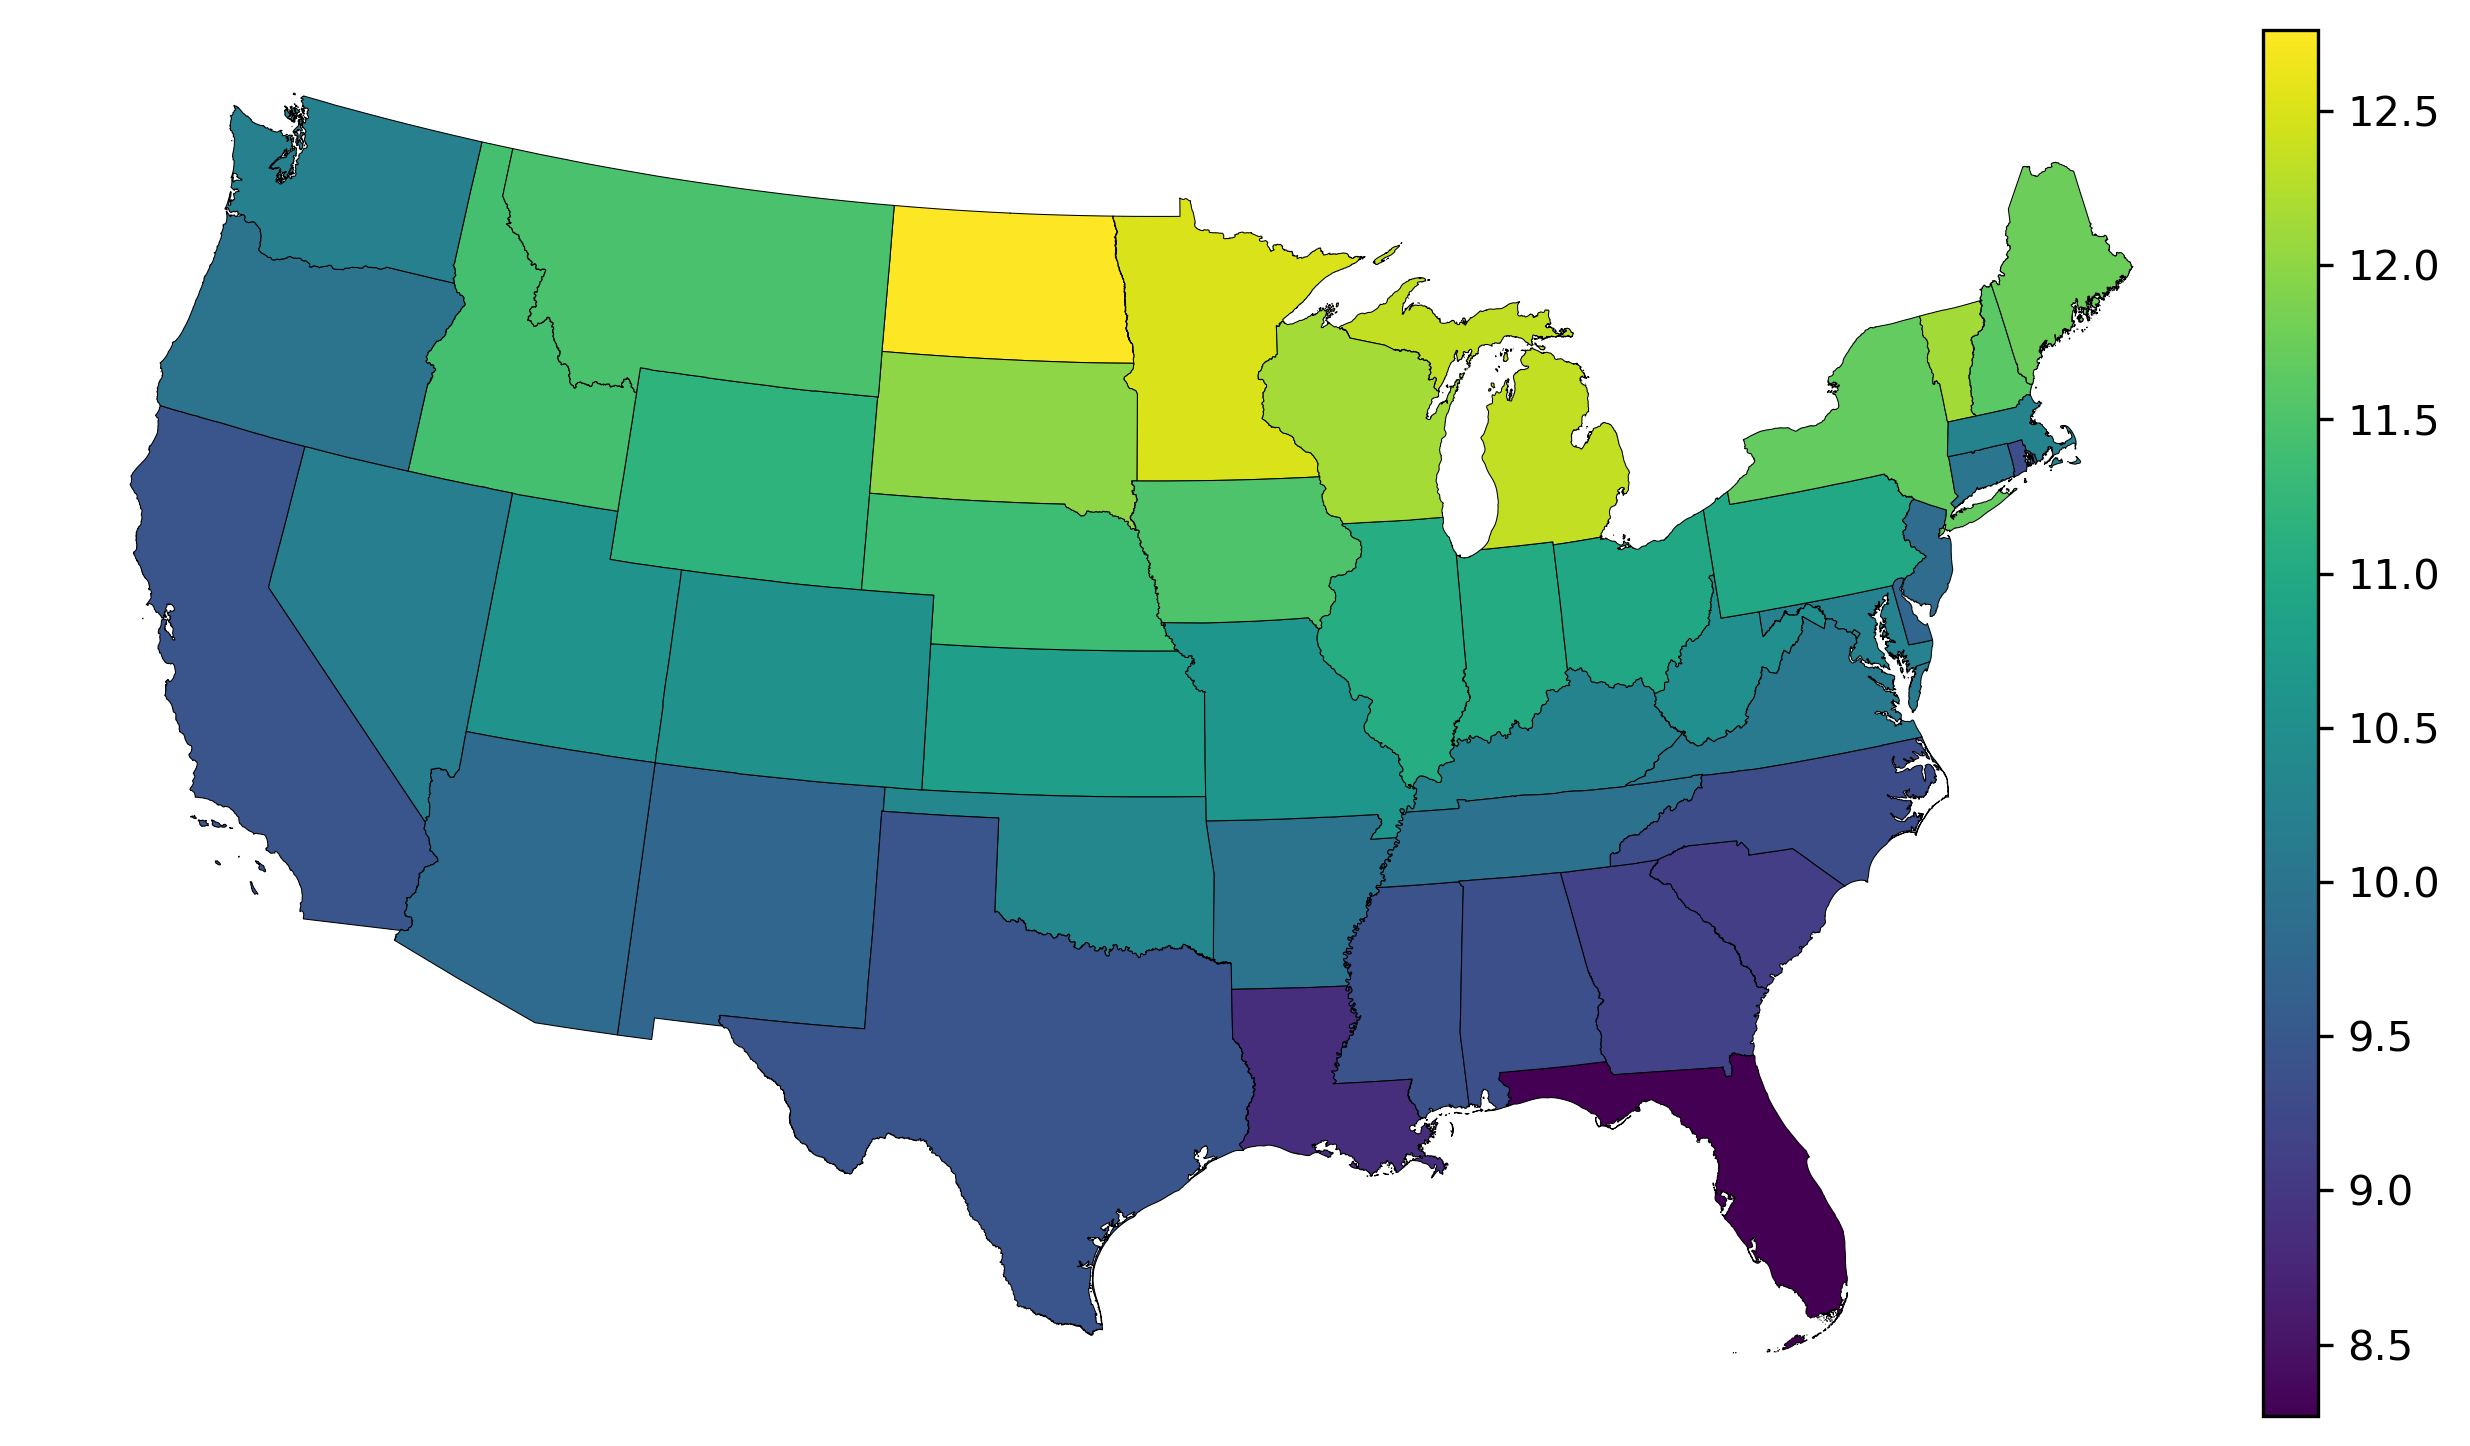

In [145]:
#And plot: Temperature change by state
###########

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi=300)

#Set up colorbar:
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.1)


#Map:
state_gdf_5070.plot(ax = ax1, column = state_gdf_5070.T_Mean_future - state_gdf_5070.T_Mean,
                    edgecolor='black', linewidth=.25, legend=True, cax=cax)

ax1.set_axis_off()


In [146]:
## What do we get for Arizona?
#######

display(state_gdf_5070.loc[state_gdf_5070.STATEFP == '04'].T_Mean)

display(state_gdf_5070.loc[state_gdf_5070.STATEFP == '04'].T_Mean_future)


39    59.966986
Name: T_Mean, dtype: float64

39    69.791637
Name: T_Mean_future, dtype: float64

#### Some more inquiries/comparisons

In [147]:
## Some quick inquiries...
#########

In [150]:
#Median state temperature:
state_gdf_5070.T_Mean.quantile(.5)

51.50163628031521

In [151]:
#Mins, historical and future:
print(state_gdf_5070.T_Mean.min())
print(state_gdf_5070.T_Mean_future.min())

40.77685390599828
52.35615834602132


In [152]:
#Maxes, historical and future:
print(state_gdf_5070.T_Mean.max())
print(state_gdf_5070.T_Mean_future.max())

70.59258878536934
78.86108441082723


Text(0.5, 1.0, 'Hotter in Future')

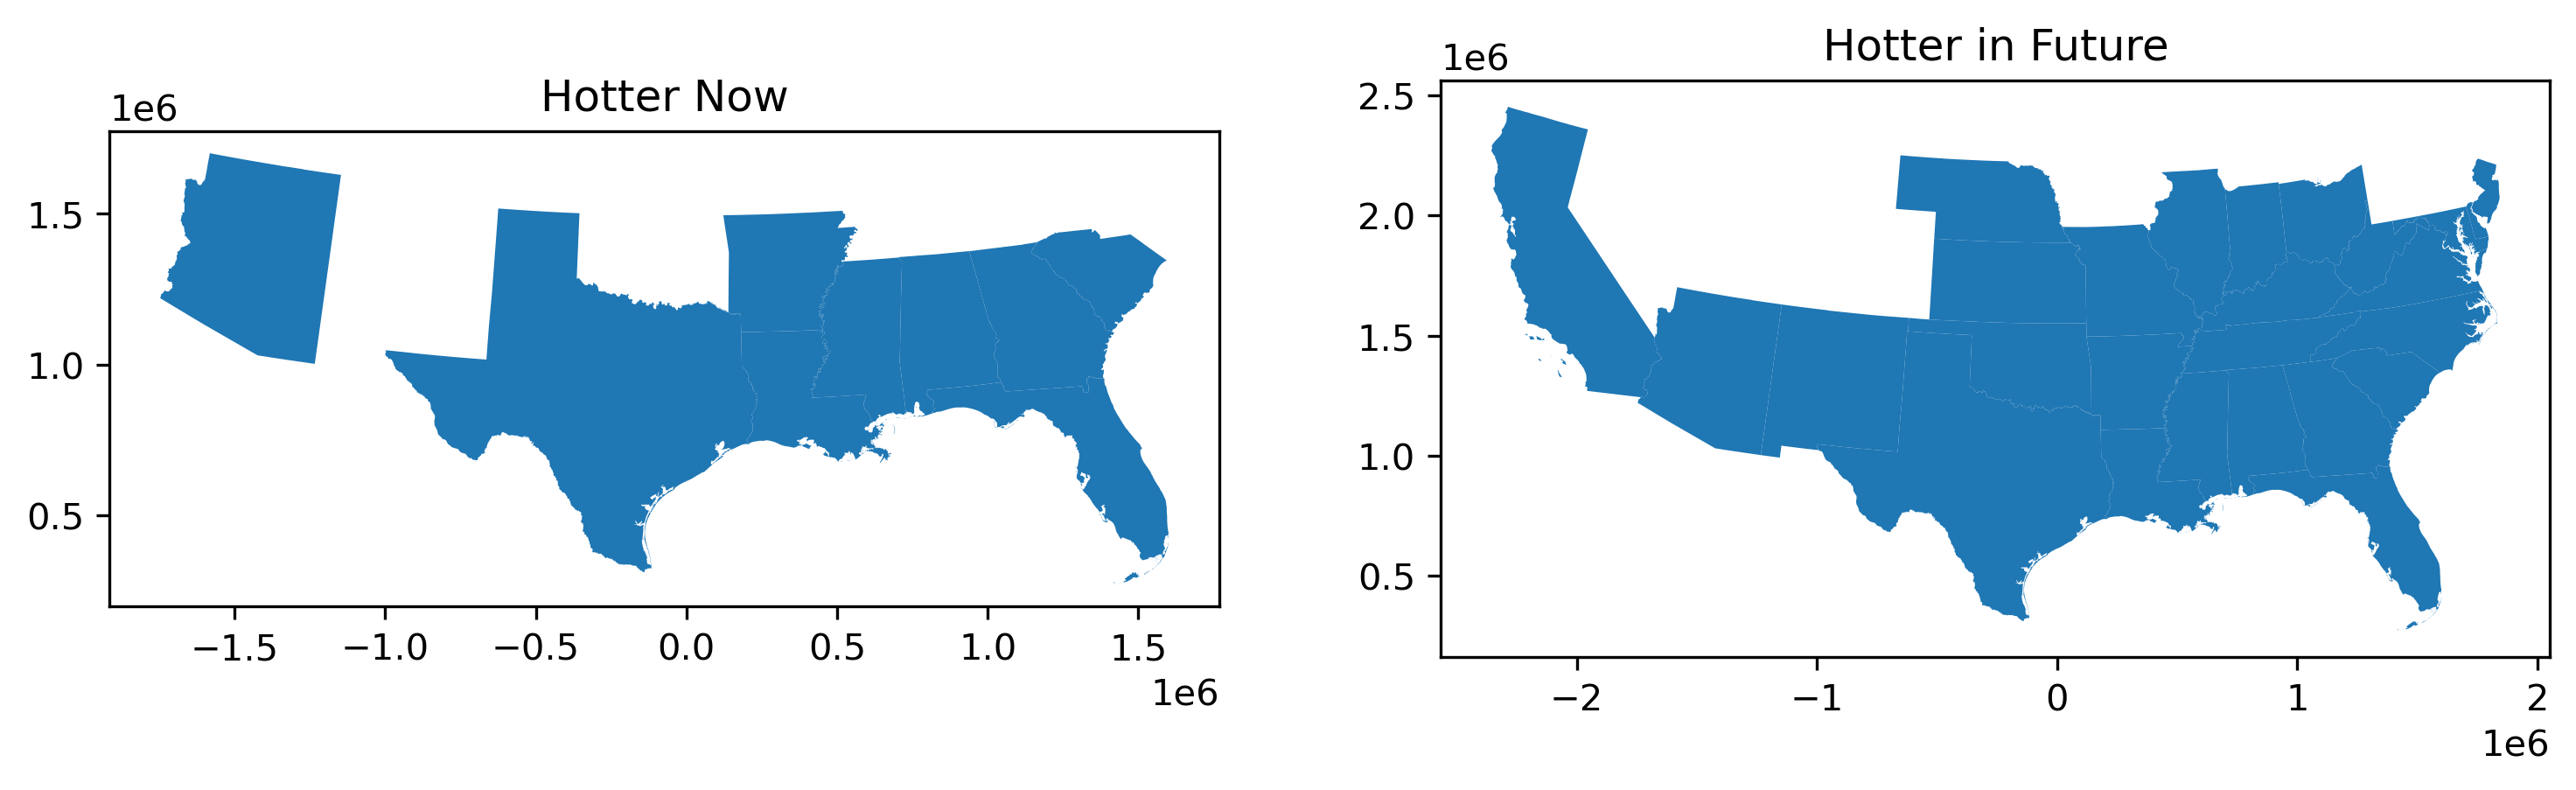

In [153]:
#And plot all states hotter in future than AZ, FL, etc:
##########

fig, ax1 = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

#For AZ:
thresh = 59.9

state_gdf_5070.loc[state_gdf_5070.T_Mean > thresh].plot(ax=ax1[0])
state_gdf_5070.loc[state_gdf_5070.T_Mean_future > thresh].plot(ax=ax1[1])


ax1[0].set_title('Hotter Now')
ax1[1].set_title('Hotter in Future')

#ax1[0].set_axis_off()
#ax1[1].set_axis_off()

Text(0.5, 1.0, 'Hotter in Future')

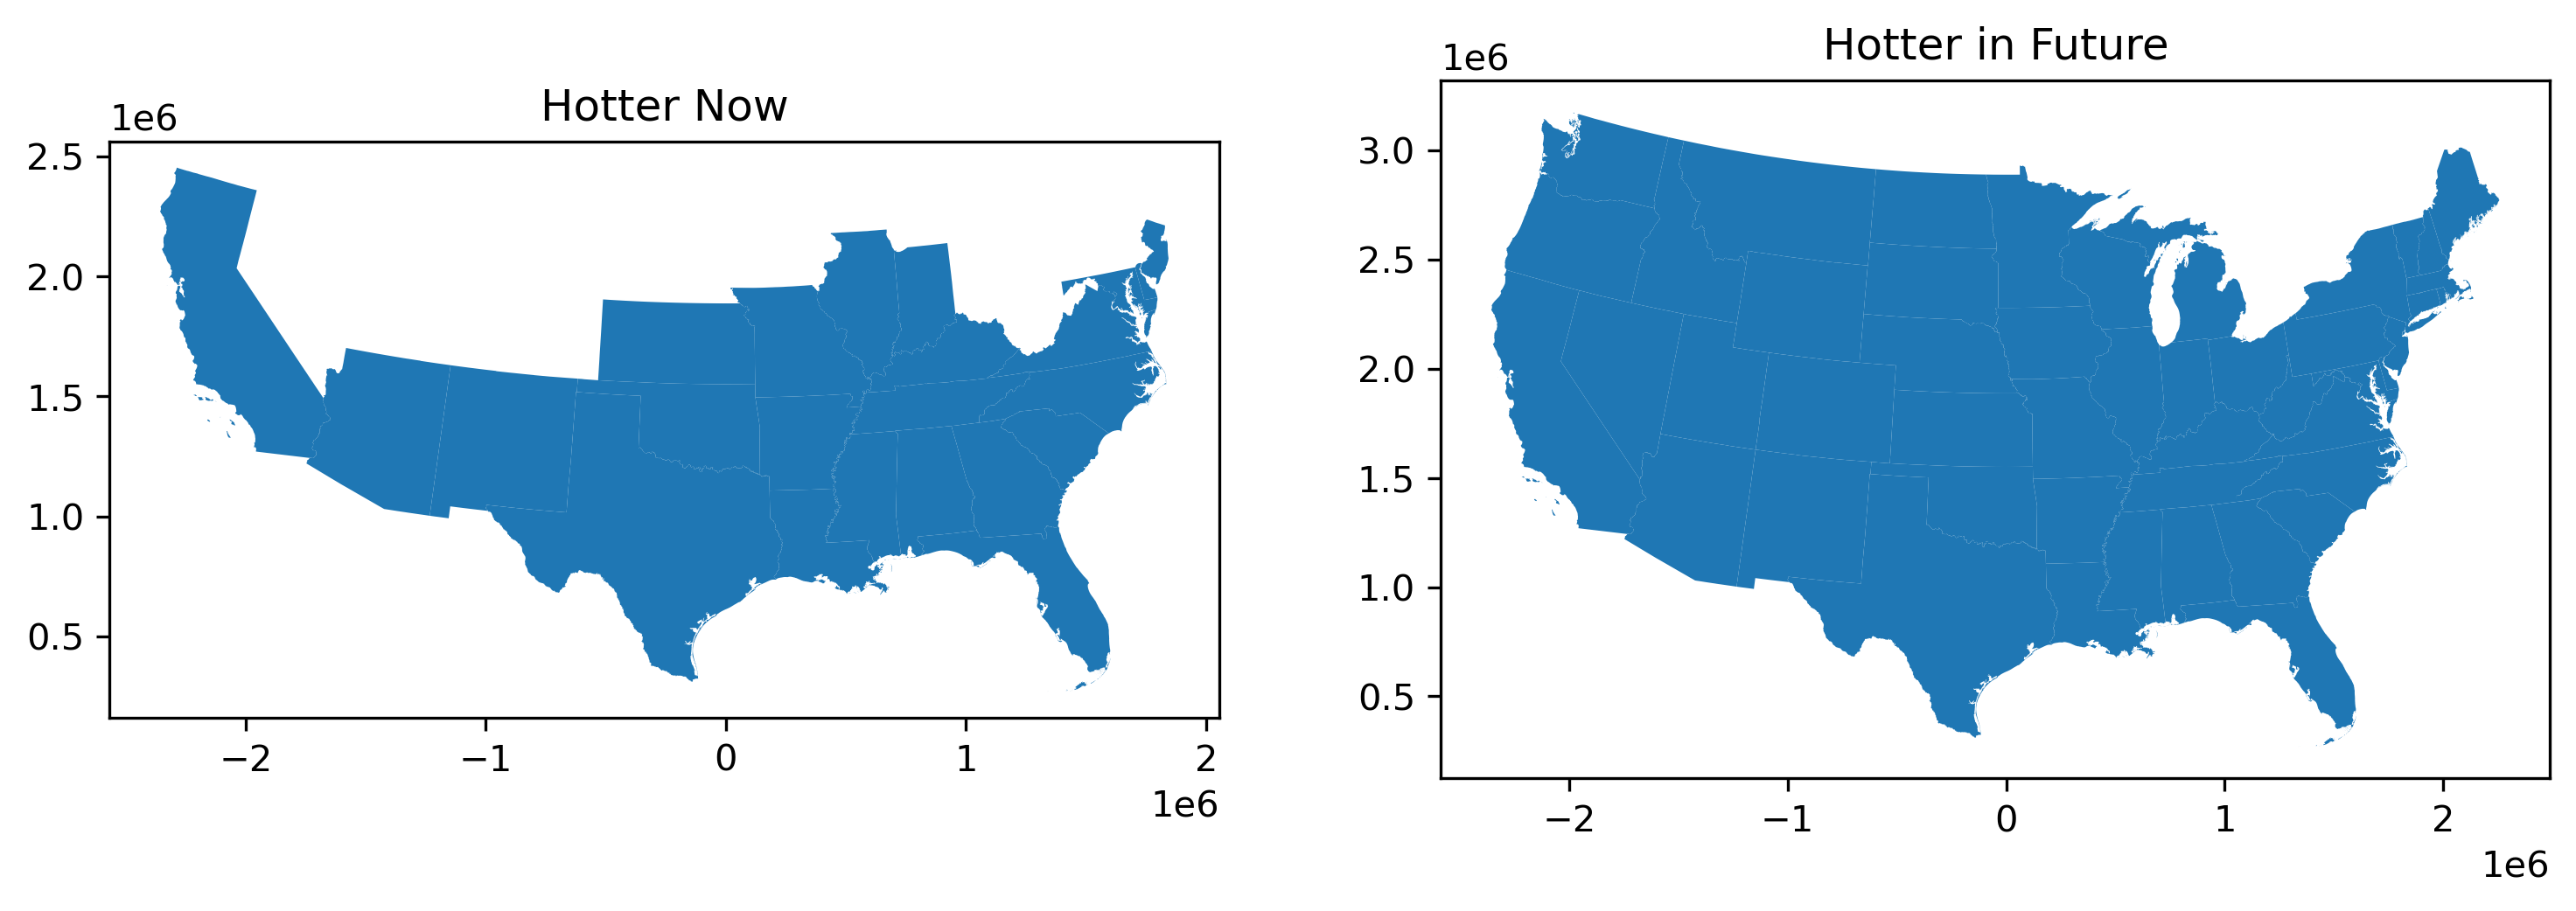

In [154]:
#And plot all states hotter in future than some quantile of current means:
##########

fig, ax1 = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

q = .5

state_gdf_5070.loc[state_gdf_5070.T_Mean > state_gdf_5070.T_Mean.quantile(q)].plot(ax=ax1[0])
state_gdf_5070.loc[state_gdf_5070.T_Mean_future > state_gdf_5070.T_Mean.quantile(q)].plot(ax=ax1[1])


ax1[0].set_title('Hotter Now')
ax1[1].set_title('Hotter in Future')

#ax1[0].set_axis_off()
#ax1[1].set_axis_off()

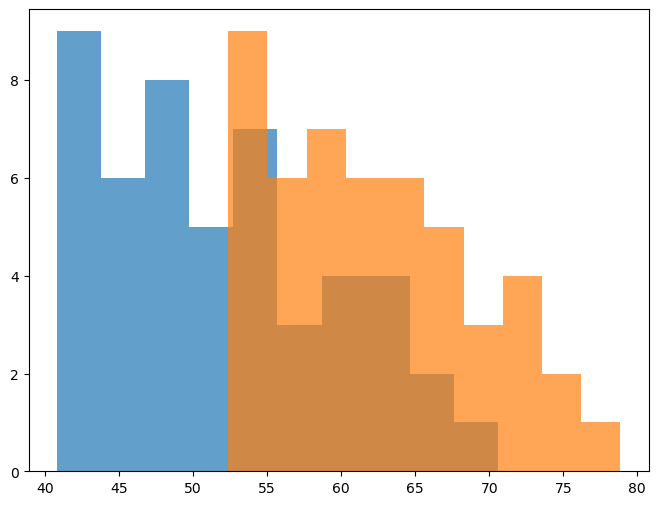

In [155]:
#Compare state distributions:
######

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

N = 10
ax1.hist(state_gdf_5070.T_Mean, bins = N, alpha=.7)
ax1.hist(state_gdf_5070.T_Mean_future, bins = N, alpha=.7);

### Compare raster distributions:

In [156]:
z1 = band1_5070_masked.flatten() * 1.8 + 32
z2 = band1_future_5070_masked.flatten() * 1.8 + 32

<AxesSubplot: ylabel='Density'>

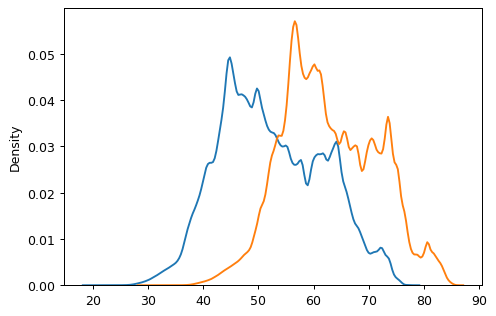

In [157]:
fig, ax1 = plt.subplots(1,1, figsize=(6, 4), dpi=90)

N = 50
sns.kdeplot(z1, ax=ax1)
sns.kdeplot(z2, ax=ax1)